# Projet: Prédiction de la demande énergétique

**IFT3395/IFT6390 - Fondements de l'apprentissage machine**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pierrelux/mlbook/blob/main/exercises/projet_energie.ipynb)

**Compétition Kaggle:** [Rejoindre la compétition](https://www.kaggle.com/t/72daeb9bff104caf912f9a0b0f42eb5a)

---

## Contexte

Hydro-Québec publie des données ouvertes sur la consommation électrique de clients participant à un programme de gestion de la demande. Ces données incluent la consommation horaire, les conditions météorologiques, et des indicateurs d'événements de pointe.

Votre mission: construire un modèle de prédiction de la consommation énergétique en utilisant **uniquement** les méthodes vues dans les chapitres 1 à 5 du cours.

## Objectifs d'apprentissage

À la fin de ce projet, vous serez en mesure de:

1. Implémenter les moindres carrés ordinaires (OLS) à partir de zéro
2. Implémenter la régression logistique avec descente de gradient
3. Appliquer la régularisation Ridge et interpréter ses effets
4. Construire un modèle à deux étages: classification → régression
5. Utiliser les probabilités prédites comme caractéristiques

## Évaluation

| Composante | Pondération | Description |
|------------|-------------|-------------|
| **Entrevue orale** | **60%** | Vérification de la compréhension |
| Code soumis | 20% | Complétion des parties 1-7 |
| Kaggle | 10% | Position au classement |
| Rapport écrit | 10% | Analyse et réflexion |

### Barème de l'entrevue orale (60%)

| Critère | Points | Ce qu'on évalue |
|---------|--------|-----------------|
| Dérivation OLS au tableau | 15 | Maîtrise de la solution analytique |
| Explication descente de gradient | 10 | Compréhension des mises à jour |
| Justification des choix | 15 | Pourquoi ces caractéristiques? Pourquoi TimeSeriesSplit? |
| Questions théoriques | 10 | Ridge = MAP, entropie croisée, etc. |
| Modifications en direct | 10 | Adapter le code et prédire les effets |

**Important**: L'entrevue orale est la composante principale de l'évaluation. Vous devez être capable d'expliquer et de justifier chaque ligne de code que vous soumettez.

### ⚠️ Avertissement sur l'utilisation d'outils IA

Les outils comme ChatGPT, Cursor, Copilot peuvent vous aider, **mais** :
- Vous devez comprendre **chaque ligne** de code que vous soumettez
- L'entrevue orale révélera rapidement si vous comprenez ou non
- **60% de la note** dépend de votre capacité à expliquer votre travail

**Conseil** : Utilisez ces outils pour apprendre, pas pour éviter d'apprendre. Du code copié sans compréhension mène à l'échec à l'entrevue orale.

---

## Partie 0: Configuration et chargement des données

Exécutez cette cellule pour importer les bibliothèques et charger les données.

In [960]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
%config InlineBackend.figure_format = 'retina'

print("Configuration terminée!")

Configuration terminée!


### Chargement des données

Les données proviennent du jeu de données ouvert [consommation-clients-evenements-pointe](https://donnees.hydroquebec.com/explore/dataset/consommation-clients-evenements-pointe/) d'Hydro-Québec. Nous les chargeons directement depuis GitHub.

In [961]:
# URLs des données sur GitHub
BASE_URL = "https://raw.githubusercontent.com/pierrelux/mlbook/main/data/"

# Charger les données
print("Chargement des données depuis GitHub...")
train = pd.read_csv(BASE_URL + "energy_train.csv", parse_dates=['horodatage_local'])

# Pour l'évaluation locale: test avec la cible (energie_kwh)
test = pd.read_csv(BASE_URL + "energy_test_avec_cible.csv", parse_dates=['horodatage_local'])

# Pour Kaggle: test sans la cible (pour générer les prédictions)
# test_kaggle = pd.read_csv(BASE_URL + "energy_test.csv", parse_dates=['horodatage_local'])
test_kaggle = test

print(f"Ensemble d'entraînement: {len(train)} observations")
print(f"Ensemble de test: {len(test)} observations")
print(f"\nPériode d'entraînement: {train['horodatage_local'].min()} à {train['horodatage_local'].max()}")
print(f"Période de test: {test['horodatage_local'].min()} à {test['horodatage_local'].max()}")

Chargement des données depuis GitHub...
Ensemble d'entraînement: 8246 observations
Ensemble de test: 1754 observations

Période d'entraînement: 2022-01-01 05:00:00+00:00 à 2024-01-31 21:00:00+00:00
Période de test: 2024-02-01 01:00:00+00:00 à 2024-07-01 03:00:00+00:00


In [962]:
# Aperçu des données
print("Colonnes disponibles:")
print(train.columns.tolist())
print(f"\nProportion événements de pointe (train): {train['evenement_pointe'].mean():.1%}")
train.head()

Colonnes disponibles:
['horodatage_local', 'poste', 'heure', 'jour', 'mois', 'jour_semaine', 'temperature_ext', 'humidite', 'vitesse_vent', 'neige', 'irradiance_solaire', 'heure_sin', 'heure_cos', 'mois_sin', 'mois_cos', 'jour_semaine_sin', 'jour_semaine_cos', 'est_weekend', 'est_ferie', 'clients_connectes', 'tstats_intelligents_connectes', 'evenement_pointe', 'energie_kwh']

Proportion événements de pointe (train): 0.9%


,horodatage_local,poste,heure,jour,mois,jour_semaine,temperature_ext,humidite,vitesse_vent,neige,...,mois_sin,mois_cos,jour_semaine_sin,jour_semaine_cos,est_weekend,est_ferie,clients_connectes,tstats_intelligents_connectes,evenement_pointe,energie_kwh
0,2022-01-01 05:00:00+00:00,A,0,1,1,7,-1.2,92,0.5,0.0,...,0.5,0.866025,-2.450000e-16,1.0,1,1,17,118,0,60.931664
1,2022-01-01 06:00:00+00:00,A,1,1,1,7,-1.3,93,1.0,0.0,...,0.5,0.866025,-2.450000e-16,1.0,1,1,17,118,0,59.117008
2,2022-01-01 07:00:00+00:00,C,2,1,1,7,-1.2,93,1.0,0.0,...,0.5,0.866025,-2.450000e-16,1.0,1,1,35,220,0,142.911665
3,2022-01-01 08:00:00+00:00,A,3,1,1,7,-1.2,94,1.0,0.0,...,0.5,0.866025,-2.450000e-16,1.0,1,1,17,118,0,52.323657
4,2022-01-01 11:00:00+00:00,A,6,1,1,7,-1.0,97,1.5,0.0,...,0.5,0.866025,-2.450000e-16,1.0,1,1,17,118,0,78.351166


### Description des variables

Les données contiennent des mesures météorologiques et temporelles pour prédire la consommation énergétique.

In [963]:
# Description des variables
print("Variables météorologiques:")
print("  - temperature_ext: Température extérieure moyenne (°C)")
print("  - humidite: Humidité relative moyenne (%)")
print("  - vitesse_vent: Vitesse du vent moyenne (km/h)")
print("  - neige: Précipitations de neige moyennes")
print("  - irradiance_solaire: Irradiance solaire moyenne")

print("\nVariables temporelles:")
print("  - heure, mois, jour, jour_semaine: Composantes temporelles")
print("  - heure_sin, heure_cos, mois_sin, mois_cos: Encodage cyclique")
print("  - est_weekend, est_ferie: Indicateurs binaires")

print("\nAutres:")
print("  - evenement_pointe: Indicateur d'événement de pointe (classification)")
print("  - energie_kwh: Variable cible (consommation en kWh)")

print(f"\nStatistiques de base:")
train[['temperature_ext', 'humidite', 'energie_kwh']].describe()

Variables météorologiques:
  - temperature_ext: Température extérieure moyenne (°C)
  - humidite: Humidité relative moyenne (%)
  - vitesse_vent: Vitesse du vent moyenne (km/h)
  - neige: Précipitations de neige moyennes
  - irradiance_solaire: Irradiance solaire moyenne

Variables temporelles:
  - heure, mois, jour, jour_semaine: Composantes temporelles
  - heure_sin, heure_cos, mois_sin, mois_cos: Encodage cyclique
  - est_weekend, est_ferie: Indicateurs binaires

Autres:
  - evenement_pointe: Indicateur d'événement de pointe (classification)
  - energie_kwh: Variable cible (consommation en kWh)

Statistiques de base:


,temperature_ext,humidite,energie_kwh
count,8246.000000,8246.000000,8246.000000
mean,5.982573,72.964831,215.906679
std,12.722433,18.063945,212.948127
min,-32.000000,16.000000,13.007400
25%,-2.600000,60.000000,90.226631
50%,5.300000,76.000000,169.503467
75%,17.000000,88.000000,294.907806
max,33.000000,100.000000,11804.198070


In [964]:
# IMPORTANT: Division temporelle déjà effectuée
# Les données de test couvrent la période à partir du 1er février 2024
# NE PAS mélanger les données - c'est une série temporelle!

print("⚠️  ATTENTION: Division temporelle")
print("Les ensembles train/test sont déjà séparés chronologiquement.")
print("N'utilisez PAS de validation croisée aléatoire (fuite d'information).")
print("\nPour la validation, utilisez une division temporelle sur train:")
print("  - Ex: train[:6000] pour entraînement, train[6000:] pour validation")

# Note: il y a un décalage de distribution entre train (hiver) et test (printemps/été)
# C'est un défi réaliste! Pensez à utiliser des caractéristiques qui généralisent bien.
print("\n📊 Décalage de distribution:")
print(f"  Train: {train['energie_kwh'].mean():.1f} kWh (hiver)")
print(f"  Test:  {test['energie_kwh'].mean():.1f} kWh (printemps/été)")
print("  → Le modèle doit généraliser à travers les saisons!")

⚠️  ATTENTION: Division temporelle
Les ensembles train/test sont déjà séparés chronologiquement.
N'utilisez PAS de validation croisée aléatoire (fuite d'information).

Pour la validation, utilisez une division temporelle sur train:
  - Ex: train[:6000] pour entraînement, train[6000:] pour validation

📊 Décalage de distribution:
  Train: 215.9 kWh (hiver)
  Test:  83.7 kWh (printemps/été)
  → Le modèle doit généraliser à travers les saisons!


### Exploration visuelle

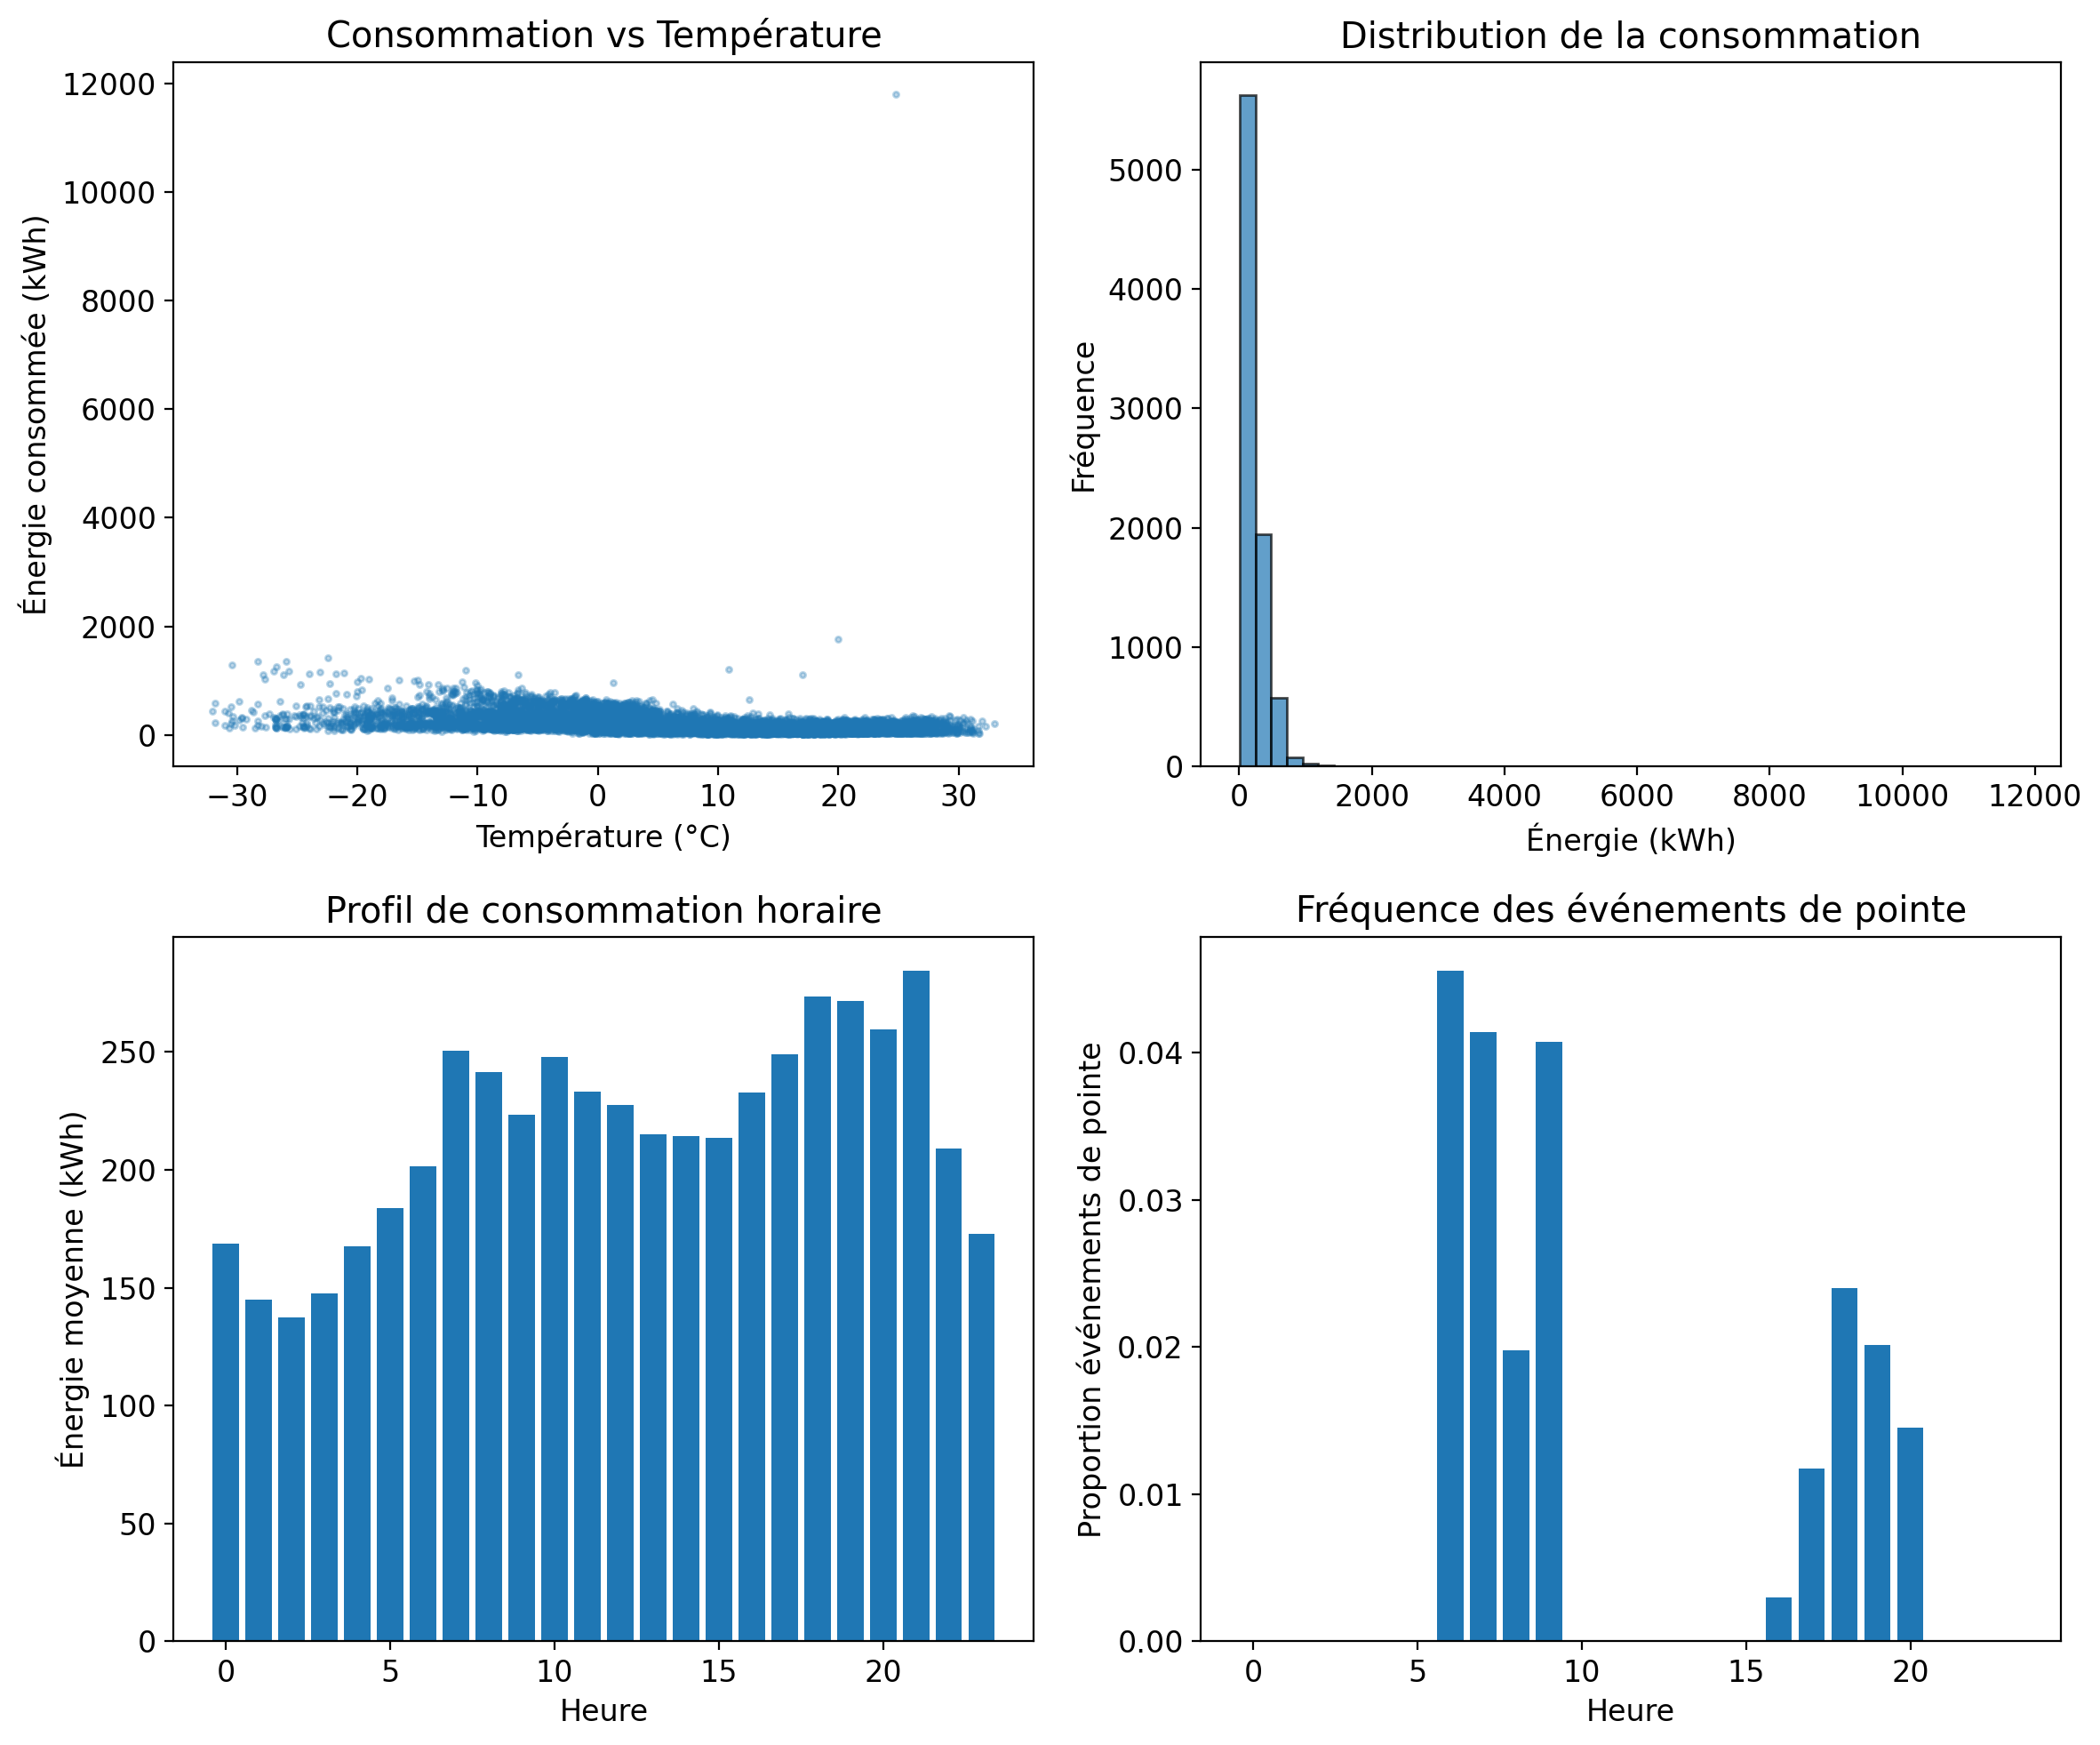

In [965]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Consommation vs température
axes[0, 0].scatter(train['temperature_ext'], train['energie_kwh'], alpha=0.3, s=5)
axes[0, 0].set_xlabel('Température (°C)')
axes[0, 0].set_ylabel('Énergie consommée (kWh)')
axes[0, 0].set_title('Consommation vs Température')

# Distribution de la consommation
axes[0, 1].hist(train['energie_kwh'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Énergie (kWh)')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].set_title('Distribution de la consommation')

# Profil horaire
profil_horaire = train.groupby('heure')['energie_kwh'].mean()
axes[1, 0].bar(profil_horaire.index, profil_horaire.values)
axes[1, 0].set_xlabel('Heure')
axes[1, 0].set_ylabel('Énergie moyenne (kWh)')
axes[1, 0].set_title('Profil de consommation horaire')

# Événements de pointe par heure
pointe_horaire = train.groupby('heure')['evenement_pointe'].mean()
axes[1, 1].bar(pointe_horaire.index, pointe_horaire.values)
axes[1, 1].set_xlabel('Heure')
axes[1, 1].set_ylabel('Proportion événements de pointe')
axes[1, 1].set_title('Fréquence des événements de pointe')

plt.tight_layout()

---

## Partie 1: Implémentation OLS (10%)

Avant d'utiliser scikit-learn, vous devez implémenter la solution analytique des moindres carrés ordinaires.

**Rappel**: La solution OLS est donnée par:

$$\hat{\boldsymbol{\beta}} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}$$

Pour des raisons de stabilité numérique, préférez `np.linalg.solve` à l'inversion directe.

In [966]:
def ols_fit(X, y):
    """
    Calcule les coefficients OLS.
    
    Paramètres:
        X : ndarray de forme (n, p) - matrice de caractéristiques (SANS colonne de 1)
        y : ndarray de forme (n,) - vecteur cible
    
    Retourne:
        beta : ndarray de forme (p+1,) - coefficients [intercept, coef1, coef2, ...]
    
    Indice: Ajoutez une colonne de 1 à X pour l'intercept.
    """

    # VOTRE CODE ICI
    # 1. Ajouter une colonne de 1 pour l'intercept
    # prepend X with a column of ones
    # [1, x1, x2, ..., xn]
    X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])

    # 2. Résoudre le système X^T X beta = X^T y
    XtX = X_with_intercept.T @ X_with_intercept
    XtY = X_with_intercept.T @ y
    beta = np.linalg.solve(XtX, XtY)

    # 3. Retourner beta
    return beta


def ols_predict(X, beta):
    """
    Prédit avec les coefficients OLS.
    
    Paramètres:
        X : ndarray de forme (n, p) - caractéristiques (SANS colonne de 1)
        beta : ndarray de forme (p+1,) - coefficients [intercept, coef1, ...]
    
    Retourne:
        y_pred : ndarray de forme (n,)
    """
    # VOTRE CODE ICI
    # predict ys by 
    # 1. matrix multiplication of X and beta, less the intercept (first column)
    # 2. add intercept
    return X @ beta[1:] + beta[0]

In [967]:
# Test de votre implémentation
# Caractéristiques simples pour commencer
features_base = ['temperature_ext', 'humidite', 'vitesse_vent']

X_train_base = train[features_base].values
y_train = train['energie_kwh'].values
X_test_base = test[features_base].values
y_test = test['energie_kwh'].values

# Votre implémentation
beta_ols = ols_fit(X_train_base, y_train)
y_pred_ols = ols_predict(X_test_base, beta_ols)

# Validation avec sklearn
model_sklearn = LinearRegression()
model_sklearn.fit(X_train_base, y_train)
y_pred_sklearn = model_sklearn.predict(X_test_base)

# Comparaison
print("Comparaison OLS implémenté vs sklearn:")
print(f"  Intercept - Vous: {beta_ols[0]:.4f}, sklearn: {model_sklearn.intercept_:.4f}")
print(f"  Coefficients proches: {np.allclose(beta_ols[1:], model_sklearn.coef_, atol=1e-4)}")
print(f"\nR² sur test: {r2_score(y_test, y_pred_ols):.4f}")

Comparaison OLS implémenté vs sklearn:
  Intercept - Vous: 234.8557, sklearn: 234.8557
  Coefficients proches: True

R² sur test: -2.2572


---

## Partie 2: Régression logistique avec descente de gradient (15%)

Implémentez la régression logistique pour la classification binaire.

**Rappels**:
- Fonction sigmoïde: $\sigma(z) = \frac{1}{1 + e^{-z}}$
- Perte d'entropie croisée: $L = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(p_i) + (1-y_i) \log(1-p_i) \right]$
- Gradient: $\nabla L = \frac{1}{n} \mathbf{X}^\top (\sigma(\mathbf{X}\boldsymbol{\beta}) - \mathbf{y})$

In [968]:
def sigmoid(z):
    """
    Fonction sigmoïde.
    
    Indice: Pour la stabilité numérique, clip z entre -500 et 500.
    """
    # VOTRE CODE ICI
    z_clipped = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z_clipped))


def cross_entropy_loss(y_true, y_pred_proba):
    """
    Calcule la perte d'entropie croisée binaire.
    
    Indice: Clip les probabilités pour éviter log(0).
    """
    # VOTRE CODE ICI
    clip_threshold = 1e-15
    y_pred_prob_clipped = np.clip(y_pred_proba, clip_threshold, 1 - clip_threshold)
    s = np.sum(y_true * np.log(y_pred_prob_clipped) + (1 - y_true) * np.log(1 - y_pred_prob_clipped))
    return -1 / (y_true.shape[0]) * s


def logistic_gradient(X, y, beta):
    """
    Calcule le gradient de la perte d'entropie croisée.
    
    Paramètres:
        X : ndarray (n, p+1) - caractéristiques AVEC colonne de 1
        y : ndarray (n,) - étiquettes binaires
        beta : ndarray (p+1,) - coefficients actuels
    
    Retourne:
        gradient : ndarray (p+1,)
    """
    # VOTRE CODE ICI
    return (1 / X.shape[0]) * (X.T @ (sigmoid(X @ beta) - y))


def logistic_fit_gd(X, y, lr=0.1, n_iter=1000, verbose=False):
    """
    Entraîne la régression logistique par descente de gradient.
    
    Paramètres:
        X : ndarray (n, p) - caractéristiques SANS colonne de 1
        y : ndarray (n,) - étiquettes binaires (0 ou 1)
        lr : float - taux d'apprentissage
        n_iter : int - nombre d'itérations
        verbose : bool - afficher la progression
    
    Retourne:
        beta : ndarray (p+1,) - coefficients [intercept, coef1, ...]
        losses : list - historique des pertes
    """
    # VOTRE CODE ICI
    verbosity_iter = n_iter // 10

    # 1. Ajouter colonne de 1 à X
    X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])

    # 2. Initialiser beta à zéro
    beta = np.zeros(X_with_intercept.shape[1])

    # 3. Boucle de descente de gradient
    losses = []
    for i in range(n_iter):
        # calculate predicted probabilities
        y_pred_prob = sigmoid(X_with_intercept @ beta)

        # calculate the loss
        loss = cross_entropy_loss(y, y_pred_prob)
        losses.append(loss)

        # calculate the gradient
        gradient = logistic_gradient(X_with_intercept, y, beta)

        # update the coefficients
        beta -= lr * gradient

        # verbose output
        if verbose and (i % verbosity_iter == 0 or i == n_iter - 1):
            print(f"Iteration {i+1}/{n_iter}, Loss: {loss:.4f}")
    
    # 4. Retourner beta et historique des pertes
    return beta, losses


def logistic_predict_proba(X, beta):
    """
    Retourne les probabilités P(Y=1|X).
    """
    # VOTRE CODE ICI
    X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
    return sigmoid(X_with_intercept @ beta)


Iteration 1/500, Loss: 0.6931
Iteration 51/500, Loss: 0.2183
Iteration 101/500, Loss: 0.1314
Iteration 151/500, Loss: 0.0995
Iteration 201/500, Loss: 0.0837
Iteration 251/500, Loss: 0.0744
Iteration 301/500, Loss: 0.0684
Iteration 351/500, Loss: 0.0642
Iteration 401/500, Loss: 0.0611
Iteration 451/500, Loss: 0.0588
Iteration 500/500, Loss: 0.0570


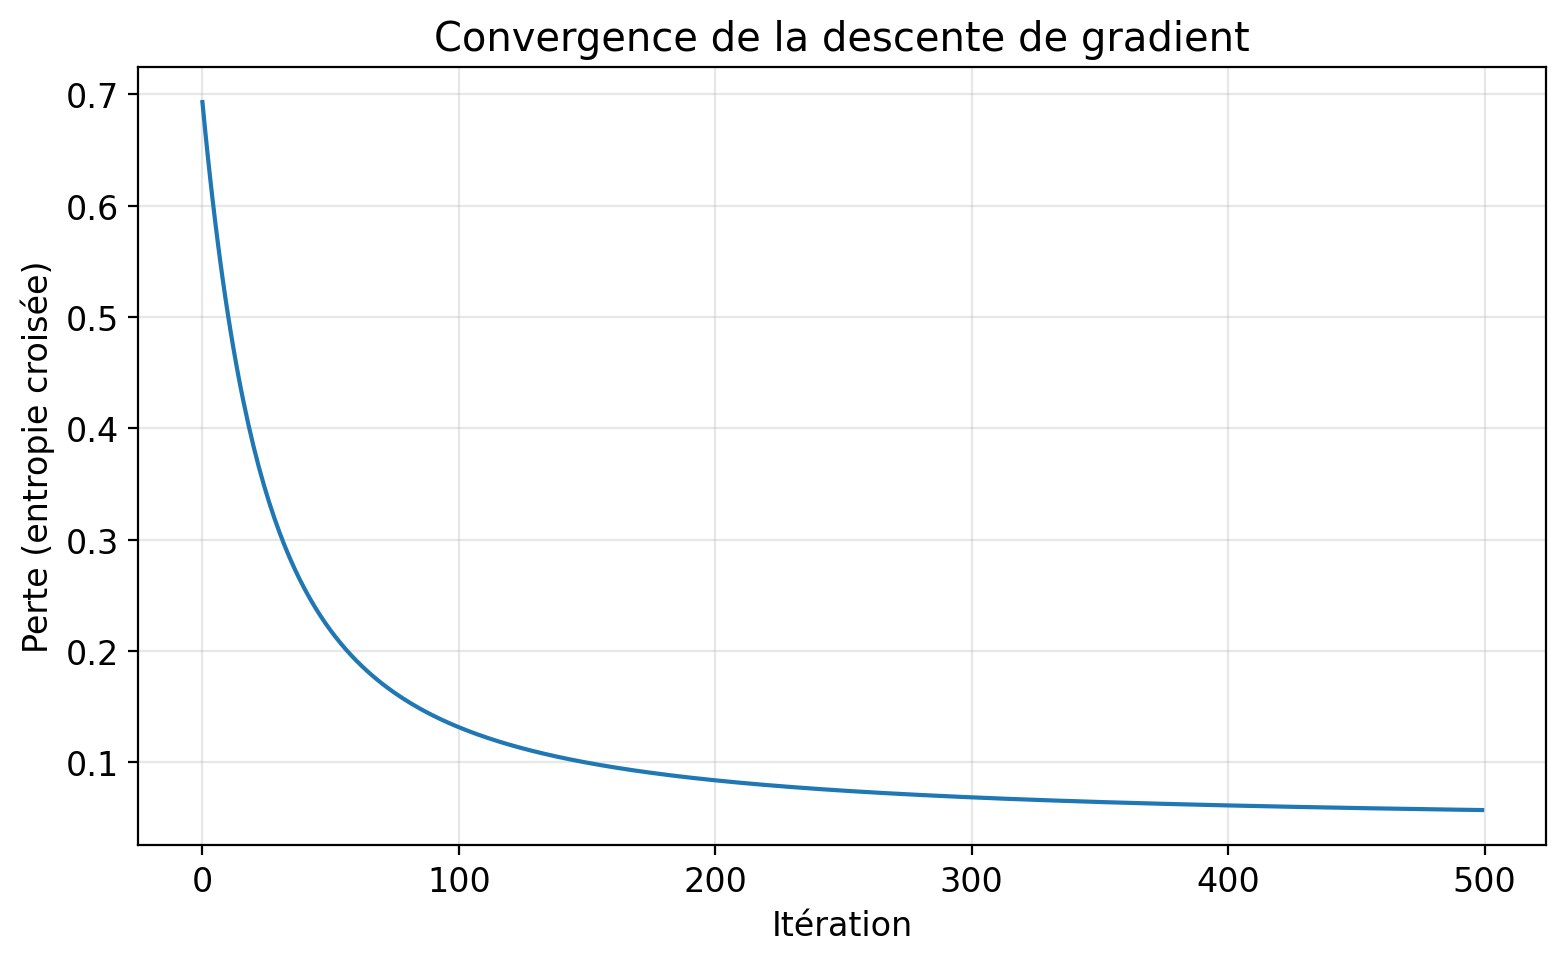

In [969]:
# Test sur la prédiction des événements de pointe
# Caractéristiques pour classification
features_clf = ['temperature_ext', 'heure_sin', 'heure_cos', 'est_weekend']

X_train_clf = train[features_clf].values
y_train_clf = train['evenement_pointe'].values
X_test_clf = test[features_clf].values
y_test_clf = test['evenement_pointe'].values

# Normaliser (recommandé pour la descente de gradient)
scaler = StandardScaler()
X_train_clf_scaled = scaler.fit_transform(X_train_clf)
X_test_clf_scaled = scaler.transform(X_test_clf)

# Entraîner votre modèle
beta_log, losses = logistic_fit_gd(X_train_clf_scaled, y_train_clf, lr=0.1, n_iter=500, verbose=True)

# Tracer la courbe de convergence
plt.figure(figsize=(8, 5))
plt.plot(losses)
plt.xlabel('Itération')
plt.ylabel('Perte (entropie croisée)')
plt.title('Convergence de la descente de gradient')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [970]:
# Évaluation
proba_train = logistic_predict_proba(X_train_clf_scaled, beta_log)
proba_test = logistic_predict_proba(X_test_clf_scaled, beta_log)

y_pred_train = (proba_train >= 0.5).astype(int)
y_pred_test = (proba_test >= 0.5).astype(int)

print("Évaluation de votre régression logistique:")
print(f"  Accuracy (train): {accuracy_score(y_train_clf, y_pred_train):.4f}")
print(f"  Accuracy (test): {accuracy_score(y_test_clf, y_pred_test):.4f}")
print(f"\nRapport de classification (test):")
print(classification_report(y_test_clf, y_pred_test, target_names=['Normal', 'Pointe']))

Évaluation de votre régression logistique:
  Accuracy (train): 0.9905
  Accuracy (test): 0.9840

Rapport de classification (test):
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      1726
      Pointe       0.00      0.00      0.00        28

    accuracy                           0.98      1754
   macro avg       0.49      0.50      0.50      1754
weighted avg       0.97      0.98      0.98      1754



---

## Partie 3: Ingénierie des caractéristiques (15%)

**À partir de maintenant, vous pouvez utiliser scikit-learn.**

Créez des caractéristiques temporelles pour améliorer le modèle de régression.

### Caractéristiques à implémenter:

1. **Retards (lags)**: consommation aux heures précédentes
2. **Statistiques glissantes**: moyenne mobile, écart-type mobile
3. **Interactions**: température × heure, etc.

Implémentez **au moins 3 nouvelles caractéristiques**.

In [ ]:
from enum import StrEnum, auto

class EngFeature(StrEnum):
    # energy
    energy_lag = auto()
    energy_rolling = auto()

    # energy proxy
    conns_scaled = auto()
    
    # temperature
    temp_heating_pow = auto()
    
    # time

    # weather
    
    # substation
    poste_c = auto()

    # interactions

    @classmethod
    def values(cls) -> list[str]:
        return [member.value for member in cls]


def create_custom_features(df: pd.DataFrame):
    conns = df['clients_connectes']
    
    ###!!! TODO explain
    conns_scaled = conns * (conns.max() / conns.rolling(window=168).max().bfill())  # 168 hours = 7 days

    energy_per_conn = df['energie_kwh'] / conns_scaled
    energy_lag = energy_per_conn.shift(1).bfill()
    energy_rolling = energy_lag.rolling(window=6).mean().bfill()

    ###!!! TODO explain clip
    energy_lag = energy_lag.clip(upper=energy_rolling * 2)  

    temp = df['temperature_ext']
    temp_heating = np.maximum(18 - temp, 0)
    temp_heating_pow = temp_heating ** 2
    temp_heating_wind = temp_heating * df['vitesse_vent']
    
    poste_one_hot = pd.get_dummies(df['poste'], prefix='poste')
    poste_c = poste_one_hot['poste_C']

    return {
        EngFeature.energy_lag: energy_lag,
        EngFeature.energy_rolling: energy_rolling,
        EngFeature.conns_scaled: conns_scaled,
        EngFeature.temp_heating_pow: temp_heating_pow,
        EngFeature.poste_c: poste_c,
    }

In [972]:
def creer_caracteristiques(df):
    """
    Crée des caractéristiques supplémentaires.
    
    VOUS DEVEZ IMPLÉMENTER AU MOINS 3 NOUVELLES CARACTÉRISTIQUES.
    
    Idées:
    - Retards: df['energie_kwh'].shift(1), shift(24)
    - Moyennes mobiles: df['energie_kwh'].rolling(6).mean()
    - Interactions: df['temperature_ext'] * df['heure_cos']
    - Degré-jours de chauffage: np.maximum(18 - df['temperature_ext'], 0)
    """
    df = df.copy()
    
    # VOTRE CODE ICI
    # Exemple:
    # df['energie_lag1'] = df['energie_kwh'].shift(1)
    # df['energie_rolling_6h'] = df['energie_kwh'].rolling(6).mean()
    # df['temp_heure_interaction'] = df['temperature_ext'] * df['heure_cos']

    # defined in previous cell
    for feature_name, feature in create_custom_features(df).items():
        df[feature_name] = feature

    return df

# Appliquer aux données
train_eng = creer_caracteristiques(train)
test_eng = creer_caracteristiques(test)

# Supprimer les lignes avec NaN (dues aux retards)
train_eng = train_eng.dropna()
test_eng = test_eng.dropna()

print(f"Nouvelles colonnes: {[c for c in train_eng.columns if c not in train.columns]}")

Nouvelles colonnes: [<EngFeature.energy_lag: 'energy_lag'>, <EngFeature.energy_rolling: 'energy_rolling'>, <EngFeature.conns_scaled: 'conns_scaled'>, <EngFeature.temp_heating_pow: 'temp_heating_pow'>, <EngFeature.poste_c: 'poste_c'>]


\---

## Partie 4: Régression Ridge (15%)

Avec plusieurs caractéristiques corrélées, la régularisation devient utile.

1. Entraînez un modèle Ridge avec validation croisée pour choisir λ
2. Comparez les performances avec OLS
3. Analysez comment les coefficients changent

In [973]:
# Définissez vos caractéristiques pour la régression
# MODIFIEZ CETTE LISTE selon vos caractéristiques créées en Partie 3
# IMPORTANT: clients_connectes est une variable très importante!
features_reg = [
    # 'temperature_ext', 
    # 'humidite', 
    # 'vitesse_vent',
    # 'irradiance_solaire',
    # 'heure_sin', 
    # 'heure_cos', 
    # 'mois_sin', 
    # 'mois_cos',
    # 'jour_semaine_sin', 
    # 'jour_semaine_cos',
    # 'est_weekend',
    # 'est_ferie',
    'clients_connectes',  # Ne pas oublier!
    # Ajoutez vos caractéristiques ici
    *EngFeature.values()
]

# Vérifier que toutes les colonnes existent
features_disponibles = [f for f in features_reg if f in train_eng.columns]
print(f"Caractéristiques utilisées: {len(features_disponibles)}")

X_train_reg = train_eng[features_disponibles].values
y_train_reg = train_eng['energie_kwh'].values
X_test_reg = test_eng[features_disponibles].values
y_test_reg = test_eng['energie_kwh'].values

Caractéristiques utilisées: 6


In [974]:
# Modèle OLS (baseline)
model_ols = LinearRegression()
model_ols.fit(X_train_reg, y_train_reg)
y_pred_ols = model_ols.predict(X_test_reg)

print("OLS (baseline):")
print(f"  R² train: {model_ols.score(X_train_reg, y_train_reg):.4f}")
print(f"  R² test:  {r2_score(y_test_reg, y_pred_ols):.4f}")
print(f"  RMSE test: {np.sqrt(mean_squared_error(y_test_reg, y_pred_ols)):.4f}")

OLS (baseline):
  R² train: 0.4774
  R² test:  0.4801
  RMSE test: 51.0143


In [975]:
# Modèle Ridge avec validation croisée
# ATTENTION: Utilisez TimeSeriesSplit pour les données temporelles!
from sklearn.model_selection import TimeSeriesSplit

# Feature scaling - important for Ridge as it penalizes based on coefficient magnitude
scaler_reg = StandardScaler()
X_train_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_scaled = scaler_reg.transform(X_test_reg)

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tscv = TimeSeriesSplit(n_splits=5)

# Fit Ridge on scaled data
model_ridge = RidgeCV(alphas=alphas, cv=tscv)
model_ridge.fit(X_train_scaled, y_train_reg)
y_pred_ridge = model_ridge.predict(X_test_scaled)

print(f"\nRidge avec scaling (λ={model_ridge.alpha_}):")
print(f"  R² train: {model_ridge.score(X_train_scaled, y_train_reg):.4f}")
print(f"  R² test:  {r2_score(y_test_reg, y_pred_ridge):.4f}")
print(f"  RMSE test: {np.sqrt(mean_squared_error(y_test_reg, y_pred_ridge)):.4f}")


Ridge avec scaling (λ=100.0):
  R² train: 0.4772
  R² test:  0.6433
  RMSE test: 42.2586


In [976]:
# Comparaison des coefficients OLS vs Ridge
coef_comparison = pd.DataFrame({
    'Caractéristique': features_disponibles,
    'OLS': model_ols.coef_,
    'Ridge': model_ridge.coef_
})
coef_comparison['Réduction (%)'] = 100 * (1 - np.abs(coef_comparison['Ridge']) / (np.abs(coef_comparison['OLS']) + 1e-8))
coef_comparison = coef_comparison.sort_values('Réduction (%)', ascending=False)

print("\nComparaison des coefficients (triés par réduction):")
print(coef_comparison.to_string(index=False))


Comparaison des coefficients (triés par réduction):
  Caractéristique        OLS     Ridge  Réduction (%)
          poste_c -26.896852  4.629743      82.787045
   energy_rolling  26.398740 41.910625     -58.759949
       energy_lag  43.420767 70.633430     -62.672000
     conns_scaled   1.843472 31.034900   -1583.502665
clients_connectes   0.964704 29.137087   -2920.313703
 temp_heating_pow   0.049307 20.109721  -40684.455341


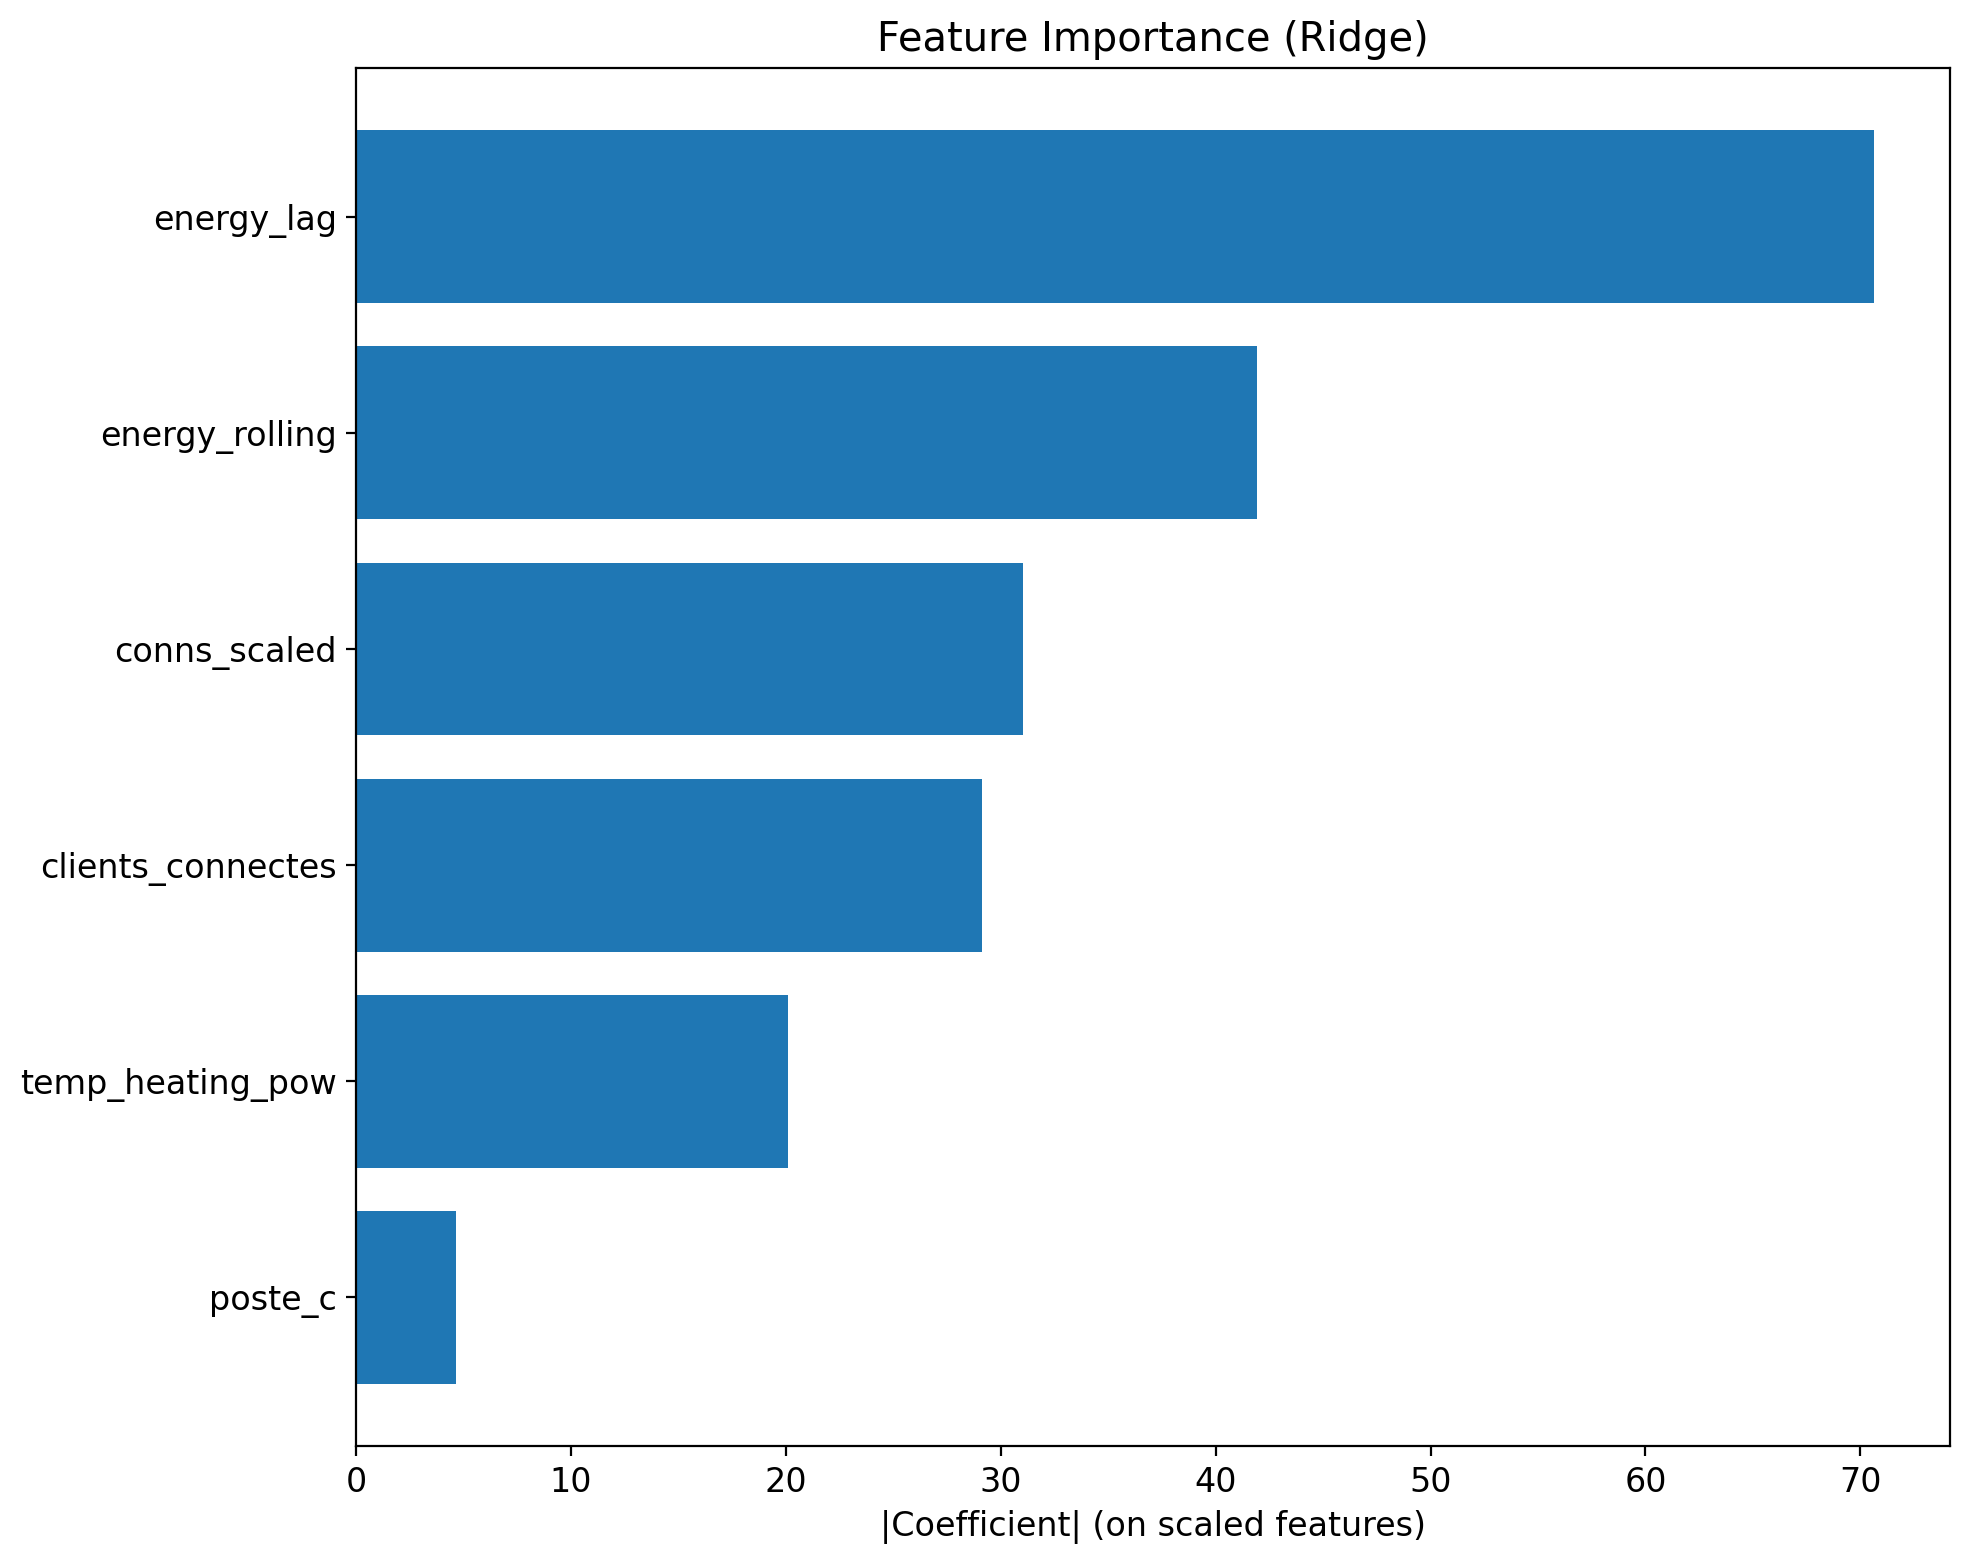

In [977]:
# Feature importance visualization (scaled coefficients are directly comparable)
sorted_idx = np.argsort(np.abs(model_ridge.coef_))
plt.figure(figsize=(10, 8))
plt.barh(np.array(features_disponibles)[sorted_idx], np.abs(model_ridge.coef_)[sorted_idx])
plt.xlabel('|Coefficient| (on scaled features)')
plt.title('Feature Importance (Ridge)')
plt.tight_layout()

SVD ANALYSIS SUMMARY

Number of features: 6
Number of samples: 8246

Singular values: [156.37 136.1   63.83  36.03  32.35   9.01]

Explained variance ratio: [49.42 37.44  8.23  2.62  2.12  0.16]%
Cumulative variance: [ 49.42  86.86  95.1   97.72  99.84 100.  ]%

Components needed for 90% variance: 3

Top 3 features per component:
  PC1: [('poste_c', np.float64(0.517)), ('conns_scaled', np.float64(0.516)), ('clients_connectes', np.float64(0.513))]
  PC2: [('temp_heating_pow', np.float64(-0.561)), ('energy_rolling', np.float64(-0.513)), ('energy_lag', np.float64(-0.508))]
  PC3: [('temp_heating_pow', np.float64(0.72)), ('clients_connectes', np.float64(-0.331)), ('energy_lag', np.float64(-0.328))]


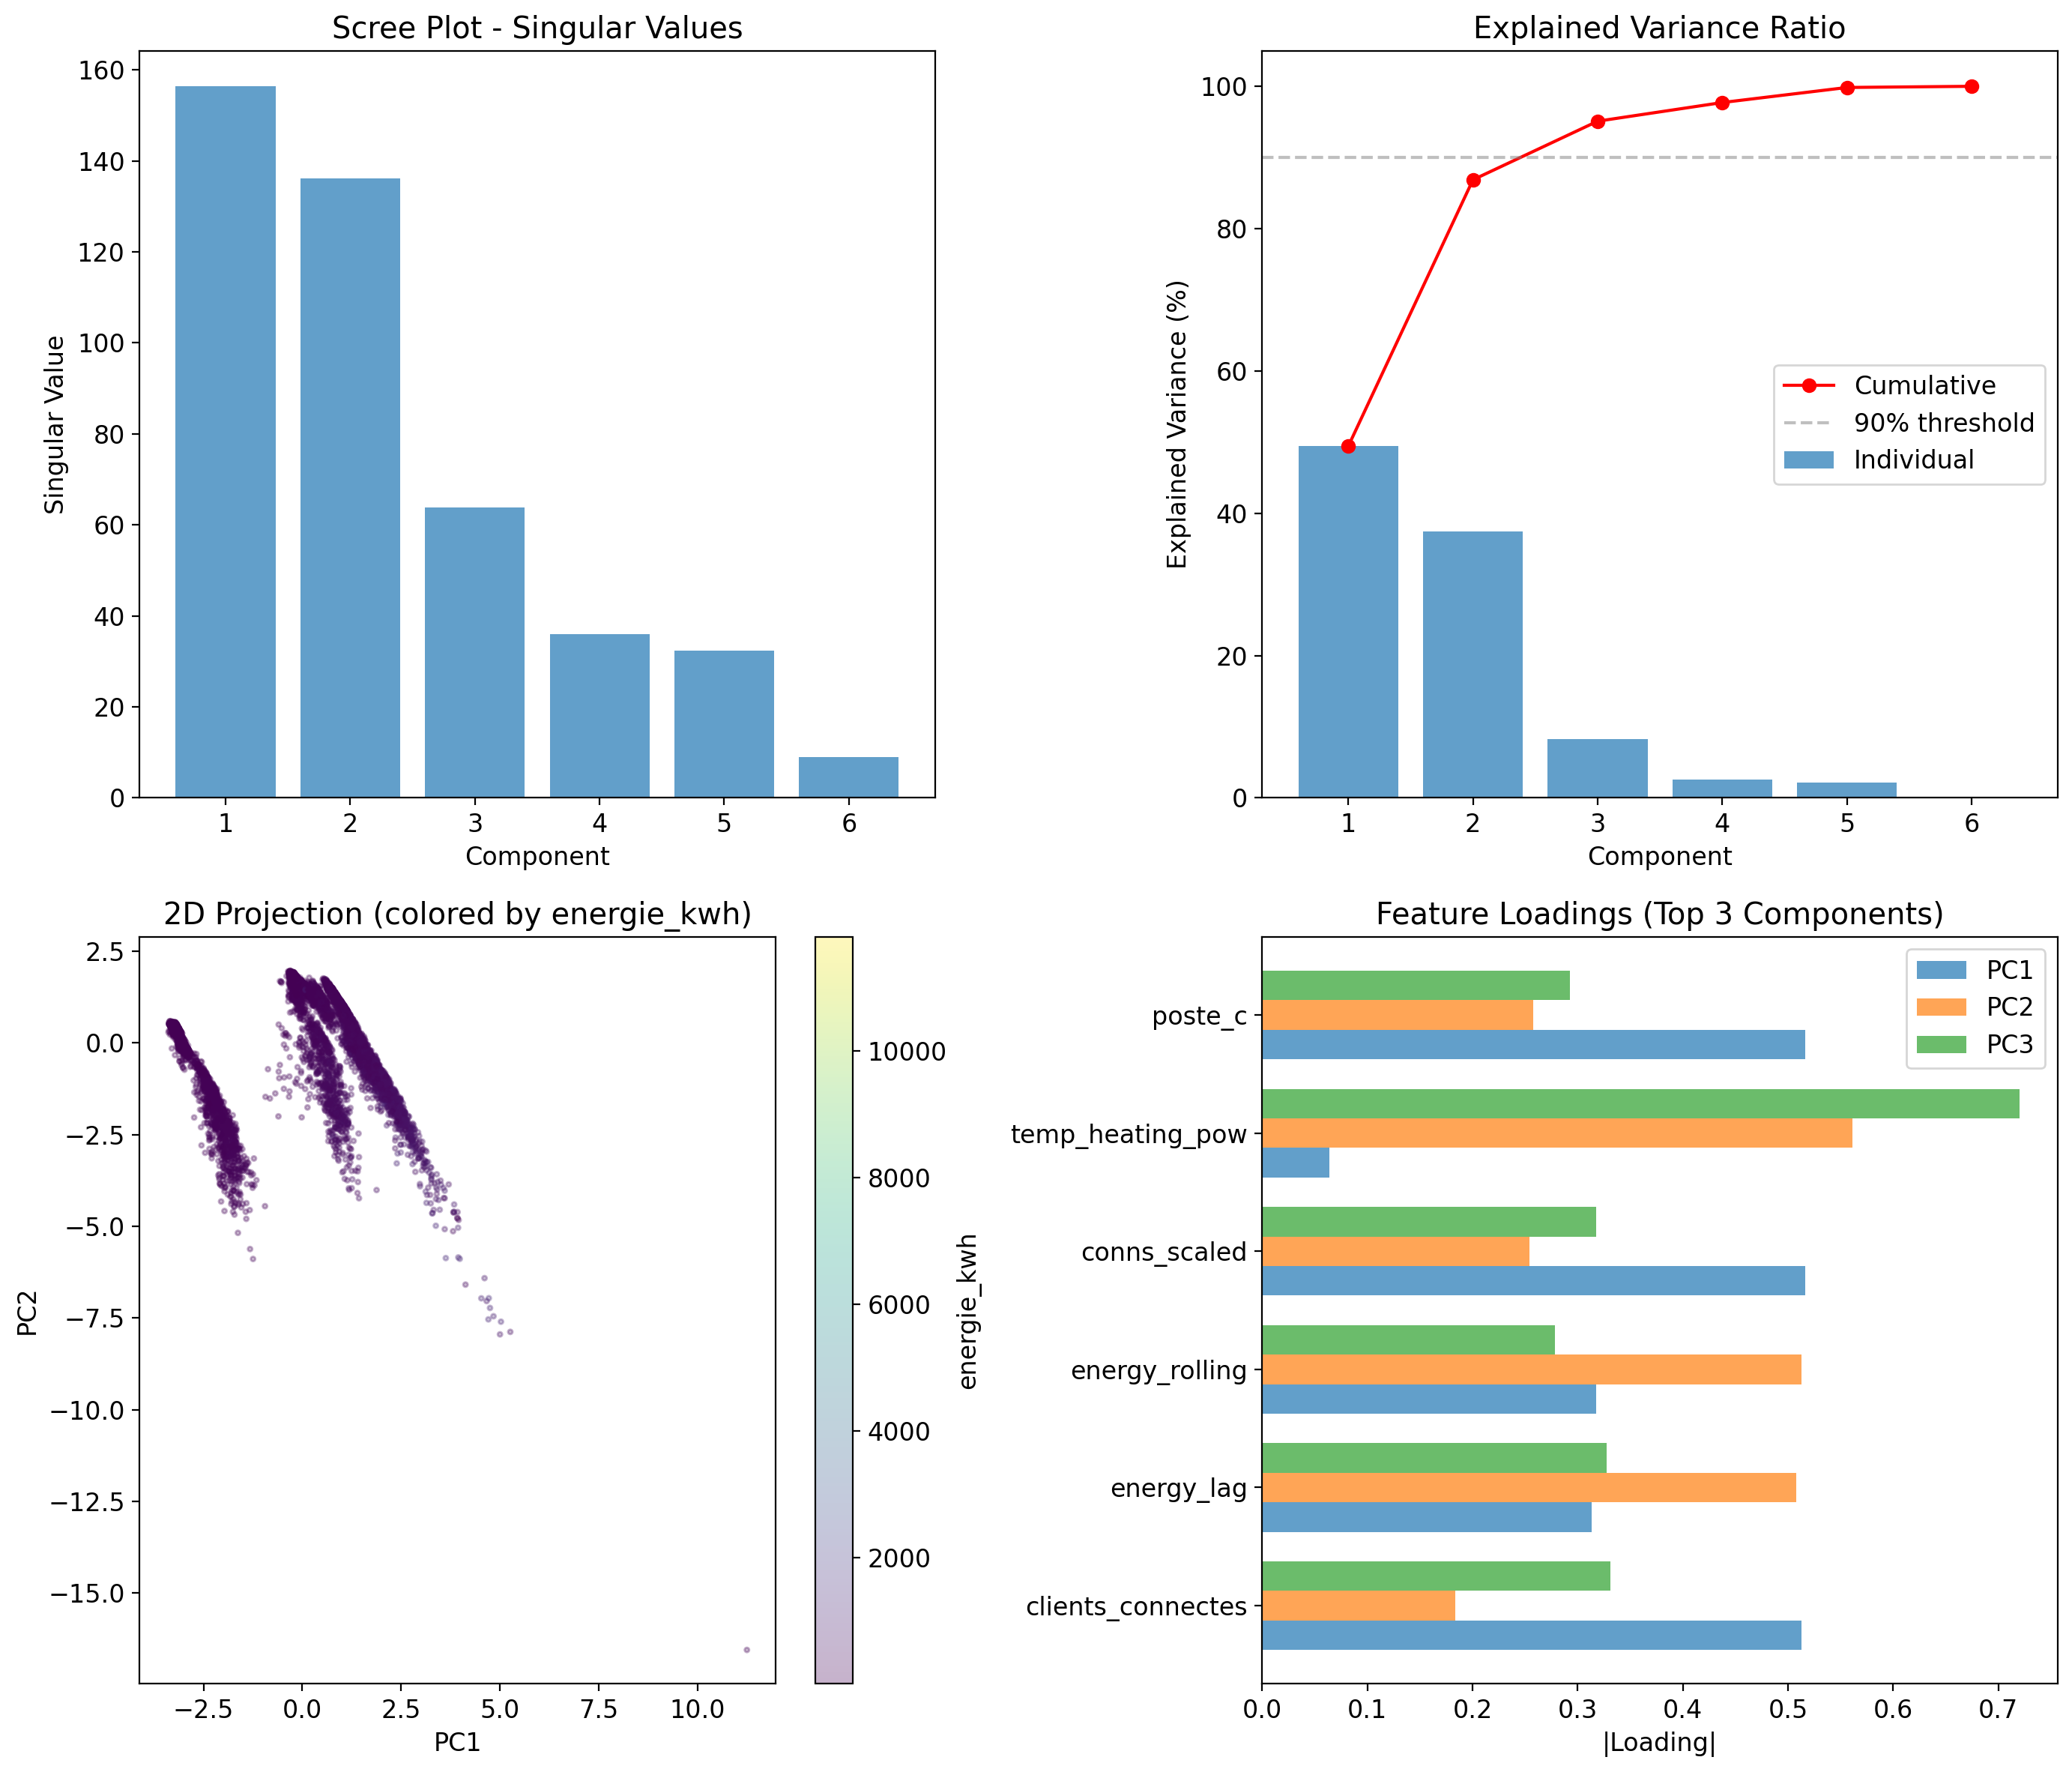

In [978]:
# SVD Analysis
from sklearn.preprocessing import StandardScaler

# Select numeric features for SVD (exclude target and non-numeric)
svd_features = features_disponibles
X_svd = X_train_scaled
y_svd = y_train_reg

# Scale features (important for SVD)
scaler_svd = StandardScaler()
X_svd_scaled = scaler_svd.fit_transform(X_svd)

# Apply SVD
U, S, Vt = np.linalg.svd(X_svd_scaled, full_matrices=False)

# Calculate explained variance ratio
explained_variance = (S ** 2) / (len(X_svd_scaled) - 1)
total_variance = explained_variance.sum()
explained_variance_ratio = explained_variance / total_variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Scree plot - Singular values
ax = axes[0, 0]
ax.bar(range(1, len(S) + 1), S, alpha=0.7, label='Singular Values')
ax.set_xlabel('Component')
ax.set_ylabel('Singular Value')
ax.set_title('Scree Plot - Singular Values')
ax.set_xticks(range(1, len(S) + 1))

# 2. Explained variance ratio
ax = axes[0, 1]
ax.bar(range(1, len(S) + 1), explained_variance_ratio * 100, alpha=0.7, label='Individual')
ax.plot(range(1, len(S) + 1), cumulative_variance_ratio * 100, 'ro-', label='Cumulative')
ax.axhline(y=90, color='gray', linestyle='--', alpha=0.5, label='90% threshold')
ax.set_xlabel('Component')
ax.set_ylabel('Explained Variance (%)')
ax.set_title('Explained Variance Ratio')
ax.set_xticks(range(1, len(S) + 1))
ax.legend()

# 3. 2D projection (first 2 principal components)
ax = axes[1, 0]
# Project data onto first 2 components
X_projected = U[:, :2] * S[:2]
scatter = ax.scatter(X_projected[:, 0], X_projected[:, 1], 
                     c=y_svd, cmap='viridis', alpha=0.3, s=5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('2D Projection (colored by energie_kwh)')
plt.colorbar(scatter, ax=ax, label='energie_kwh')

# 4. Feature loadings for top 3 components
ax = axes[1, 1]
n_components = 3
loadings = Vt[:n_components, :].T  # Features x Components
x_pos = np.arange(len(svd_features))
width = 0.25
for i in range(n_components):
    ax.barh(x_pos + i * width, np.abs(loadings[:, i]), width, label=f'PC{i+1}', alpha=0.7)
ax.set_yticks(x_pos + width)
ax.set_yticklabels(svd_features)
ax.set_xlabel('|Loading|')
ax.set_title('Feature Loadings (Top 3 Components)')
ax.legend()

plt.tight_layout()

# Print summary
print("=" * 60)
print("SVD ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nNumber of features: {len(svd_features)}")
print(f"Number of samples: {len(X_svd_scaled)}")
print(f"\nSingular values: {S.round(2)}")
print(f"\nExplained variance ratio: {(explained_variance_ratio * 100).round(2)}%")
print(f"Cumulative variance: {(cumulative_variance_ratio * 100).round(2)}%")

# Components needed for 90% variance
n_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
print(f"\nComponents needed for 90% variance: {n_90}")

# Top features for each component
print("\nTop 3 features per component:")
for i in range(min(3, len(S))):
    top_idx = np.argsort(np.abs(Vt[i, :]))[::-1][:3]
    top_features = [(svd_features[j], Vt[i, j].round(3)) for j in top_idx]
    print(f"  PC{i+1}: {top_features}")

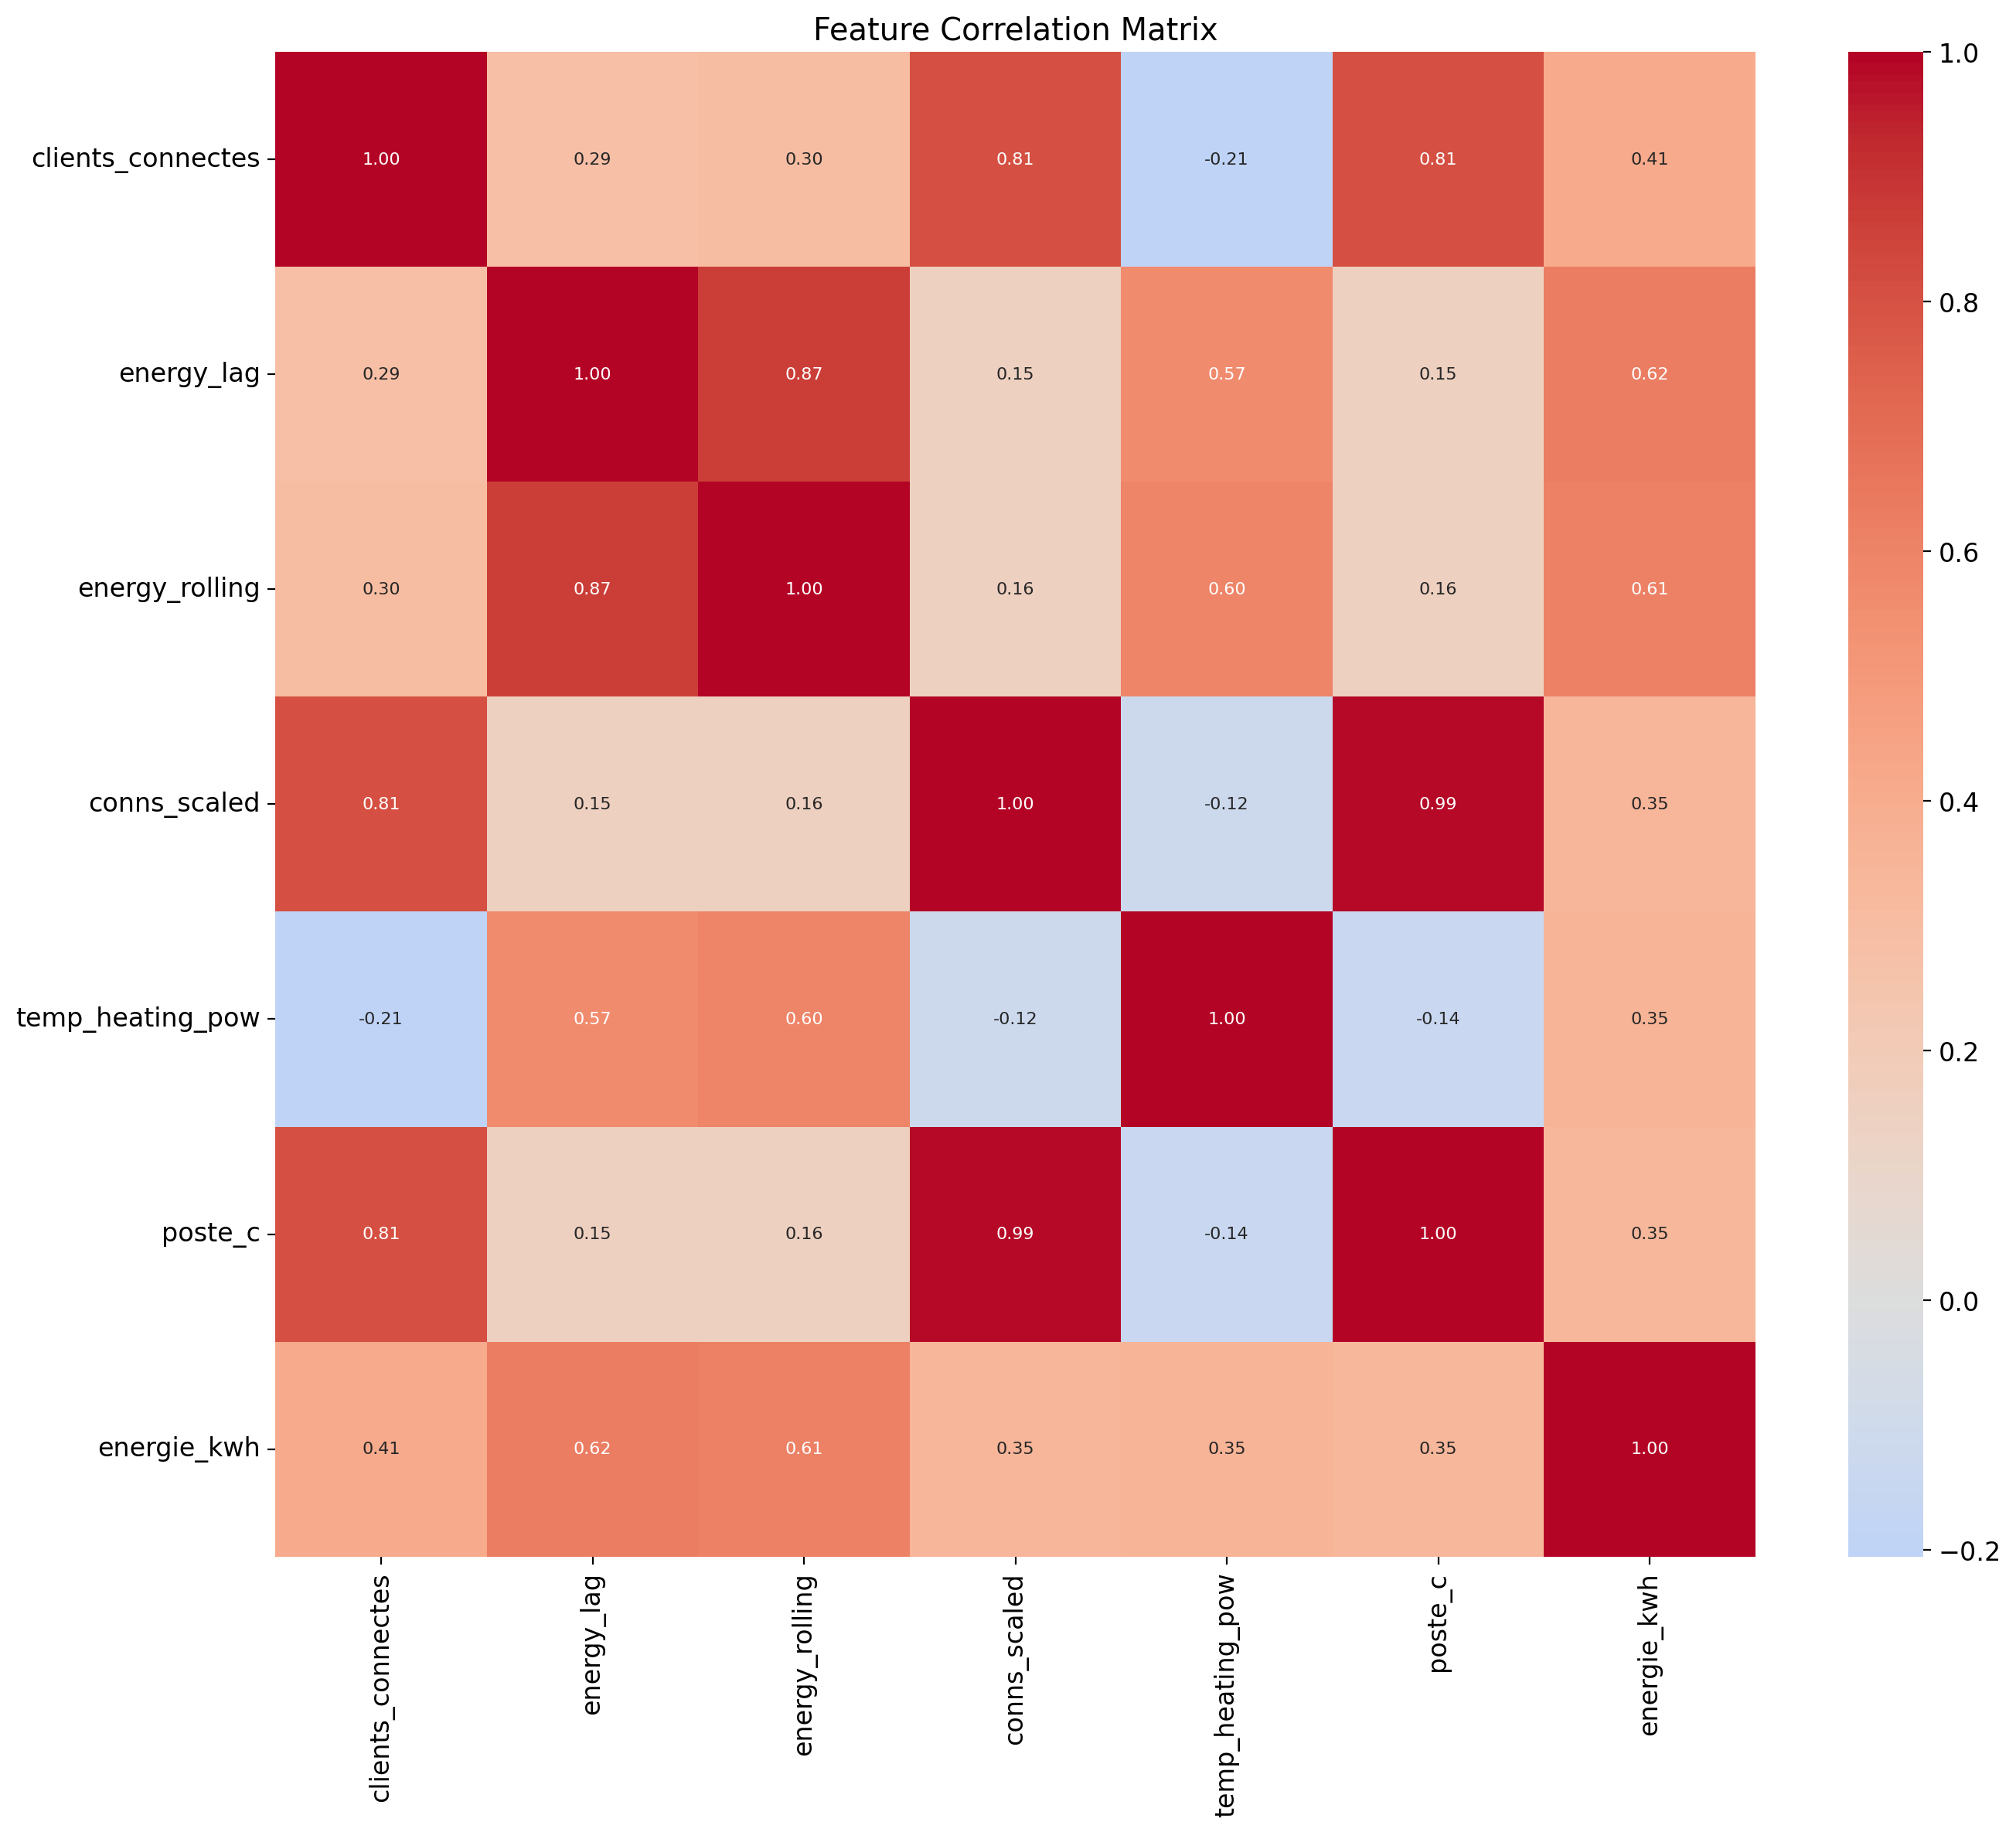

In [979]:
# Correlation matrix to understand feature relationships
import seaborn as sns

corr_df = train_eng[features_disponibles + ['energie_kwh']].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            annot_kws={'size': 8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()

**Questions pour l'entrevue orale**:
- Pourquoi Ridge aide-t-il quand les caractéristiques sont corrélées?
- Quelle caractéristique a été la plus réduite? Pourquoi?
- Comment interpréter Ridge comme estimation MAP?

---

## Partie 5: Sous-tâche de classification (15%)

Entraînez un classifieur pour prédire les événements de pointe, puis utilisez la probabilité prédite comme caractéristique pour la régression.

**Étapes**:
1. Entraîner LogisticRegression sur `evenement_pointe`
2. Extraire `P(pointe)` pour chaque observation
3. Ajouter cette probabilité comme caractéristique pour Ridge

In [980]:
# Caractéristiques pour la classification
# Utilisez des caractéristiques qui ne "trichent" pas (pas de consommation passée pour prédire la pointe)
# features_pointe = ['temperature_ext', 'humidite', 'vitesse_vent', 'heure_sin', 'heure_cos', 'est_weekend', 'clients_connectes']
features_pointe = features_disponibles

X_train_pointe = train_eng[features_pointe].values
y_train_pointe = train_eng['evenement_pointe'].values
X_test_pointe = test_eng[features_pointe].values
y_test_pointe = test_eng['evenement_pointe'].values

# Entraîner le classifieur avec class_weight='balanced' pour gérer le déséquilibre de classes
# Sans cela, le modèle prédit toujours "Normal" car 99.1% des données sont "Normal"
clf_pointe = LogisticRegression(max_iter=1000, class_weight='balanced')
clf_pointe.fit(X_train_pointe, y_train_pointe)

# Évaluation
y_pred_pointe = clf_pointe.predict(X_test_pointe)
print("Classification des événements de pointe:")
print(f"  Accuracy (train): {clf_pointe.score(X_train_pointe, y_train_pointe):.4f}")
print(f"  Accuracy (test): {clf_pointe.score(X_test_pointe, y_test_pointe):.4f}")
print(f"\nRapport de classification (test):")
print(classification_report(y_test_pointe, y_pred_pointe, target_names=['Normal', 'Pointe']))

Classification des événements de pointe:
  Accuracy (train): 0.9126
  Accuracy (test): 0.8900

Rapport de classification (test):
              precision    recall  f1-score   support

      Normal       1.00      0.89      0.94      1726
      Pointe       0.12      0.93      0.21        28

    accuracy                           0.89      1754
   macro avg       0.56      0.91      0.58      1754
weighted avg       0.98      0.89      0.93      1754



In [981]:
# Extraire les probabilités
train_eng['P_pointe'] = clf_pointe.predict_proba(X_train_pointe)[:, 1]
test_eng['P_pointe'] = clf_pointe.predict_proba(X_test_pointe)[:, 1]

print('Distribution de P(pointe):')
print(f'  Train: moyenne={train_eng["P_pointe"].mean():.3f}, std={train_eng["P_pointe"].std():.3f}')
print(f'  Test:  moyenne={test_eng["P_pointe"].mean():.3f}, std={test_eng["P_pointe"].std():.3f}')

Distribution de P(pointe):
  Train: moyenne=0.111, std=0.244
  Test:  moyenne=0.131, std=0.272


**Question pour l'entrevue**: Pourquoi utiliser P(pointe) au lieu d'un indicateur 0/1?

---

## Partie 6: Modèle combiné (10%)

Assemblez le modèle final en ajoutant `P_pointe` comme caractéristique.

In [982]:
# Caractéristiques finales (avec P_pointe)
features_final = features_disponibles + ['P_pointe']  # Same as Ridge features

X_train_final = train_eng[features_final].values
y_train_final = train_eng['energie_kwh'].values
X_test_final = test_eng[features_final].values
y_test_final = test_eng['energie_kwh'].values

# add standardization
scaler_final = StandardScaler()
X_train_final_scaled = scaler_final.fit_transform(X_train_final)
X_test_final_scaled = scaler_final.transform(X_test_final)

# Modèle Ridge final
model_final = RidgeCV(alphas=[0.1, 1, 10, 100], cv=TimeSeriesSplit(n_splits=5))
model_final.fit(X_train_final, y_train_final)
y_pred_final = model_final.predict(X_test_final)

print("Modèle final (Ridge + P_pointe):")
print(f"  λ sélectionné: {model_final.alpha_}")
print(f"  R² train: {model_final.score(X_train_final, y_train_final):.4f}")
print(f"  R² test:  {r2_score(y_test_final, y_pred_final):.4f}")
print(f"  RMSE test: {np.sqrt(mean_squared_error(y_test_final, y_pred_final)):.4f}")

Modèle final (Ridge + P_pointe):
  λ sélectionné: 100.0
  R² train: 0.4775
  R² test:  0.5720
  RMSE test: 46.2877


In [983]:
# Comparaison: avec vs sans P_pointe
print("\n=== Récapitulatif ===")
print(f"OLS baseline:     R² = {r2_score(y_test_reg, y_pred_ols):.4f}")
print(f"Ridge:            R² = {r2_score(y_test_reg, y_pred_ridge):.4f}")
print(f"Ridge + P_pointe: R² = {r2_score(y_test_final, y_pred_final):.4f}")
print(f"\nAmélioration due à P_pointe: {100*(r2_score(y_test_final, y_pred_final) - r2_score(y_test_reg, y_pred_ridge)):.2f}%")


=== Récapitulatif ===
OLS baseline:     R² = 0.4801
Ridge:            R² = 0.6433
Ridge + P_pointe: R² = 0.5720

Amélioration due à P_pointe: -7.13%


In [984]:
# remove P_point feature. it made hurt the prediction
y_test_final = y_test_reg
y_pred_final = y_pred_ridge
features_final = features_disponibles
scaler_final = scaler_reg
model_final = model_ridge

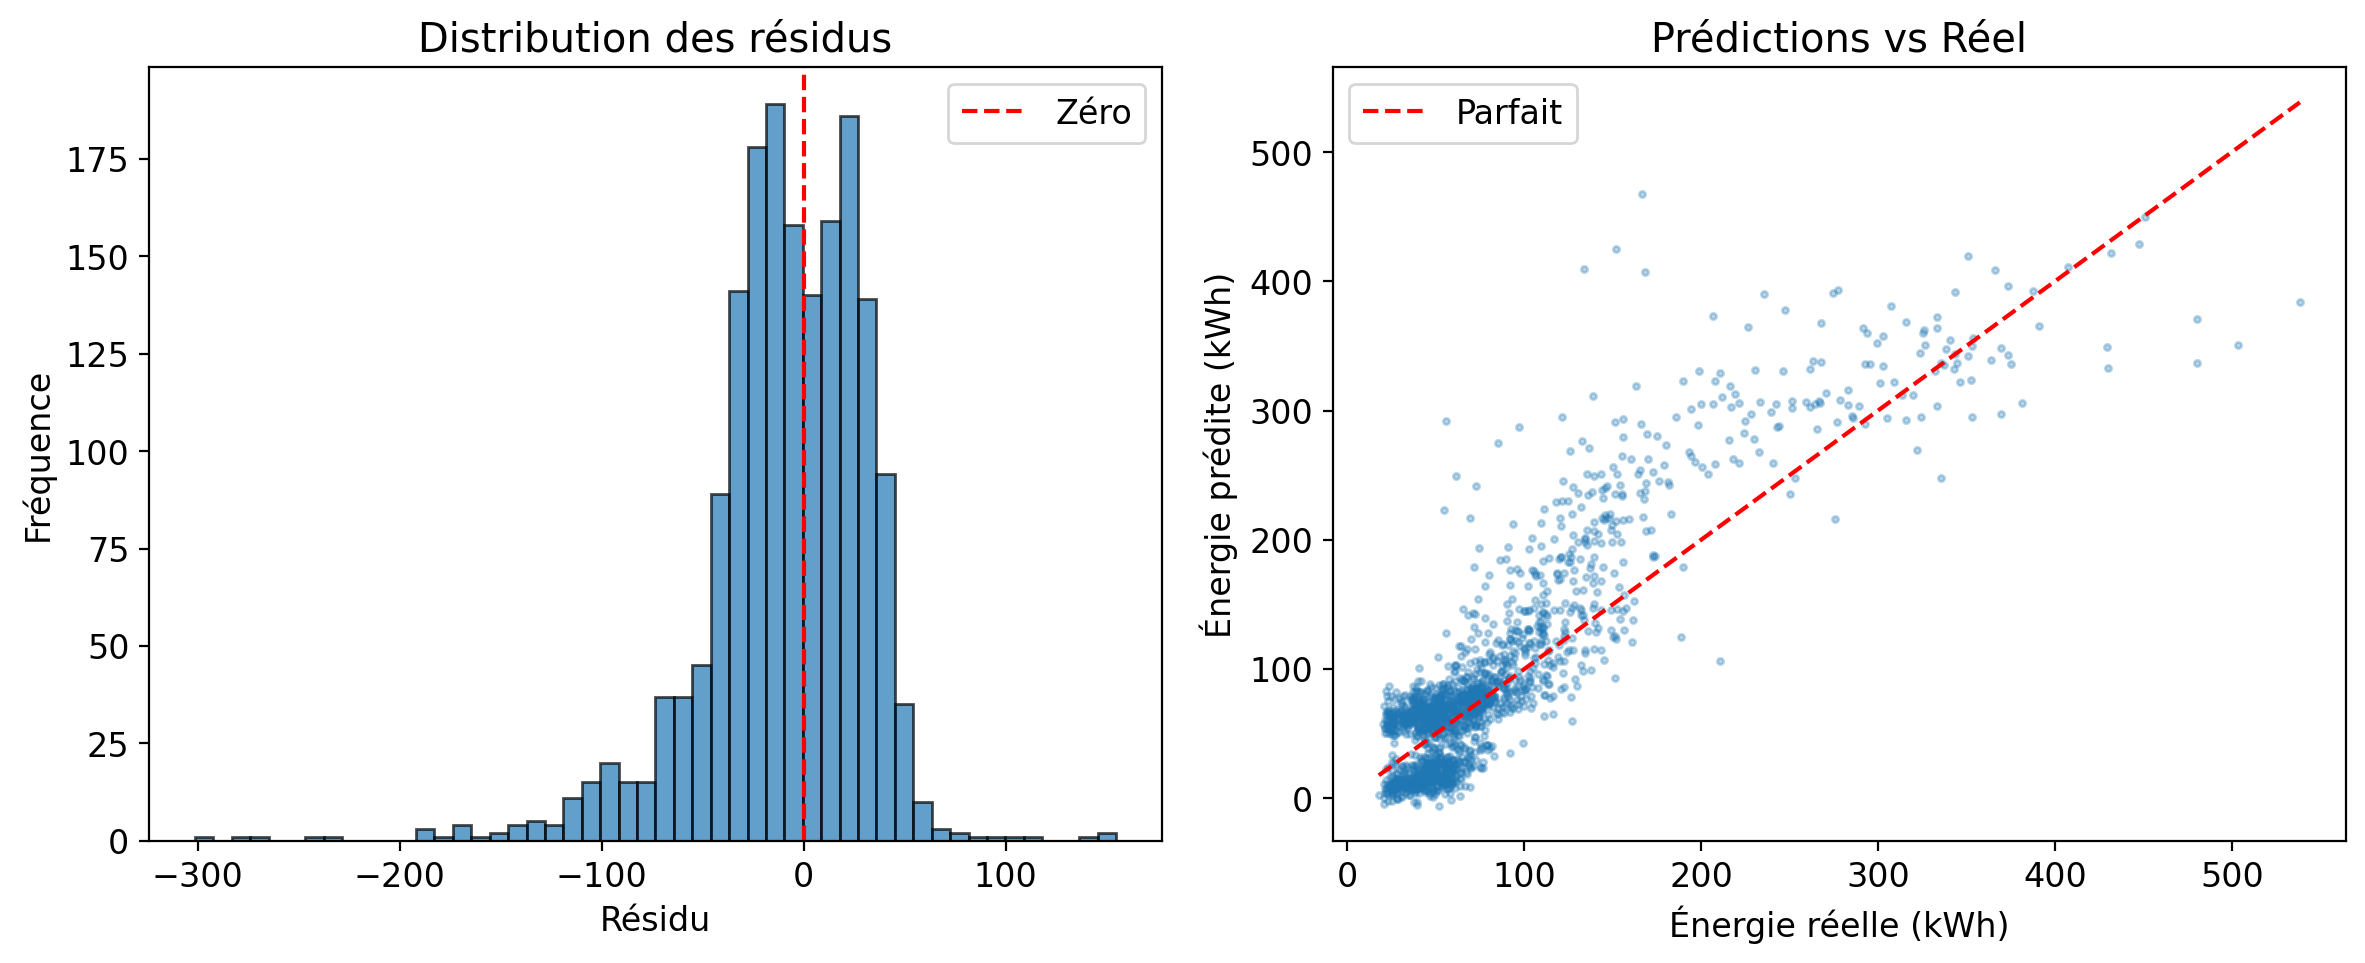

In [985]:
# Visualisation des résidus
## remove P_point
# residus = y_test_final - y_pred_final
residus = y_test_final - y_pred_ridge

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogramme des résidus
axes[0].hist(residus, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', label='Zéro')
axes[0].set_xlabel('Résidu')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des résidus')
axes[0].legend()

# Prédictions vs réel
axes[1].scatter(y_test_final, y_pred_final, alpha=0.3, s=5)
axes[1].plot([y_test_final.min(), y_test_final.max()], 
             [y_test_final.min(), y_test_final.max()], 'r--', label='Parfait')
axes[1].set_xlabel('Énergie réelle (kWh)')
axes[1].set_ylabel('Énergie prédite (kWh)')
axes[1].set_title('Prédictions vs Réel')
axes[1].legend()

plt.tight_layout()

---

## Partie 7: Extension (10%) - Choisir UNE option

### Option A: Données météorologiques externes
Utilisez la bibliothèque `meteostat` pour ajouter des données météo supplémentaires (ex: pression atmosphérique, point de rosée).

### Option B: Classification multiclasse
Au lieu de binaire (pointe/normal), créez 3+ classes de consommation (faible/moyenne/élevée) et utilisez softmax.

### Option C: Analyse d'erreur approfondie
Identifiez quand le modèle fait le plus d'erreurs et proposez des améliorations.

In [986]:
# Option B: Multi-class Classification (Softmax)
# Instead of binary (peak/normal), create 3+ consumption classes (low/medium/high)
# and use softmax (multinomial logistic regression)

# 1. Define consumption classes based on percentiles from training data
p_medium_percentile = 0.25
p_high_percentile = 0.75
p_medium = train_eng['energie_kwh'].quantile(p_medium_percentile)
p_high = train_eng['energie_kwh'].quantile(p_high_percentile)

print('Class thresholds (training)')
print(f'  Low:    energie_kwh < {p_medium:.1f} kWh')
print(f'  Medium: {p_medium:.1f} <= energie_kwh < {p_high:.1f} kWh')
print(f'  High:   energie_kwh >= {p_high:.1f} kWh')

Class thresholds (training)
  Low:    energie_kwh < 90.2 kWh
  Medium: 90.2 <= energie_kwh < 294.9 kWh
  High:   energie_kwh >= 294.9 kWh


In [987]:
# 2. Create class labels using pd.cut (vectorized, more pandas-ish)
bins = [-np.inf, p_medium, p_high, np.inf]
labels = [0, 1, 2]  # Low, Medium, High

for df in [train_eng, test_eng]:
    df['consumption_class'] = pd.cut(
        df['energie_kwh'], bins=bins, labels=labels
    ).astype(int)

# Class distribution
print('\nClass distribution')
class_names = ['Low', 'Medium', 'High']
train_dist = train_eng['consumption_class'].value_counts(normalize=True).sort_index()
test_dist = test_eng['consumption_class'].value_counts(normalize=True).sort_index()

for i, name in enumerate(class_names):
    train_pct = train_dist.get(i, 0) * 100
    test_pct = test_dist.get(i, 0) * 100
    print(f'  {name}: Train {train_pct:.1f}%, Test {test_pct:.1f}%')
print('\nThe classification rates in the test set indicate')
print('  1. Energy consumption tends to be much lower during warm months')
print('  1. The model does not appreciate the distribution shift in the test data')


Class distribution
  Low: Train 25.0%, Test 73.0%
  Medium: Train 50.0%, Test 23.7%
  High: Train 25.0%, Test 3.3%

The classification rates in the test set indicate
  1. Energy consumption tends to be much lower during warm months
  1. The model does not appreciate the distribution shift in the test data


In [988]:
# 3. Train multinomial logistic regression (softmax)
# Features for classification (don't use energy as feature - that's what we're predicting!)
features_multiclass = [
    'temperature_ext',
    'humidite', 
    'vitesse_vent', 
    'irradiance_solaire',
    'heure_sin', 
    'heure_cos', 
    'mois_sin', 
    'mois_cos',
    'clients_connectes', 
    'est_weekend',
    # Engineered features
    *EngFeature.values(),
]

X_train_mc = train_eng[features_multiclass].values
y_train_mc = train_eng['consumption_class'].values
X_test_mc = test_eng[features_multiclass].values
y_test_mc = test_eng['consumption_class'].values

# scale features
scaler_mc = StandardScaler()
X_train_mc_scaled = scaler_mc.fit_transform(X_train_mc)
X_test_mc_scaled = scaler_mc.transform(X_test_mc)

# train multinomial logistic regression (softmax)
clf_multiclass = LogisticRegression(max_iter=1000)
clf_multiclass.fit(X_train_mc_scaled, y_train_mc)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [989]:
# 5. Get class probabilities (softmax outputs)
train_proba_mc = clf_multiclass.predict_proba(X_train_mc_scaled)
test_proba_mc = clf_multiclass.predict_proba(X_test_mc_scaled)

# Add probability features to dataframes
features = {
    'p_low': 0, 
    'p_medium': 1,
    'p_high': 2,
}
for dfs in [(train_eng, train_proba_mc), (test_eng, test_proba_mc)]:
    for feature, label in features.items():
        dfs[0][feature] = dfs[1][:, label]

# print classification distributions
print('\nClass probability distributions')
for x in [('train', train_eng), ('test', test_eng)]:
    name = x[0]
    df = x[1]
    print(f'{name}:')
    for feature in ['p_low', 'p_medium', 'p_high']:
        print(f"  {feature}:\tmean={df[feature].mean():.3f},\tstd={df[feature].std():.3f}")


Class probability distributions
train:
  p_low:	mean=0.250,	std=0.387
  p_medium:	mean=0.500,	std=0.404
  p_high:	mean=0.250,	std=0.371
test:
  p_low:	mean=0.620,	std=0.391
  p_medium:	mean=0.324,	std=0.349
  p_high:	mean=0.057,	std=0.199


In [990]:
# 4. Evaluate the classifier
y_pred_mc = clf_multiclass.predict(X_test_mc_scaled)

print('\nMC results')
print(f'\ttrain acc: {clf_multiclass.score(X_train_mc_scaled, y_train_mc):.4f}')
print(f'\ttest acc:  {clf_multiclass.score(X_test_mc_scaled, y_test_mc):.4f}')
print('\nClassification Report (test):')
print(classification_report(y_test_mc, y_pred_mc, target_names=class_names))


MC results
	train acc: 0.8947
	test acc:  0.8529

Classification Report (test):
              precision    recall  f1-score   support

         Low       0.97      0.87      0.92      1281
      Medium       0.66      0.79      0.72       415
        High       0.51      0.97      0.67        58

    accuracy                           0.85      1754
   macro avg       0.71      0.87      0.77      1754
weighted avg       0.88      0.85      0.86      1754



In [991]:
# 6. Use class probabilities as features for Ridge regression
# Note: We only use 2 of 3 probabilities (they sum to 1, so P_medium is redundant)
features_with_proba = features_disponibles + ['p_low', 'p_high']

X_train_proba = train_eng[features_with_proba].values
y_train_proba = train_eng['energie_kwh'].values
X_test_proba = test_eng[features_with_proba].values
y_test_proba = test_eng['energie_kwh'].values

# Scale features
scaler_proba = StandardScaler()
X_train_proba_scaled = scaler_proba.fit_transform(X_train_proba)
X_test_proba_scaled = scaler_proba.transform(X_test_proba)

# Train Ridge with probability features
model_with_proba = RidgeCV(alphas=[0.1, 1, 10, 100, 1000], cv=TimeSeriesSplit(n_splits=5))
model_with_proba.fit(X_train_proba_scaled, y_train_proba)
y_pred_with_proba = model_with_proba.predict(X_test_proba_scaled)

print('\nRegression with class probabilities')
print(f'Ridge with softmax probabilities (λ={model_with_proba.alpha_}):')
print(f'\tR² train: {model_with_proba.score(X_train_proba_scaled, y_train_proba):.4f}')
print(f'\tR² test:  {r2_score(y_test_proba, y_pred_with_proba):.4f}')
print(f'\tRMSE test: {np.sqrt(mean_squared_error(y_test_proba, y_pred_with_proba)):.4f}')

# 7. Compare with baseline
print("\nModel comparison")
baseline_r2 = r2_score(y_test_final, y_pred_final)
proba_r2 = r2_score(y_test_proba, y_pred_with_proba)
improvement = (proba_r2 - baseline_r2) / abs(baseline_r2) * 100
print(f'\tBaseline Ridge (no probabilities): R² = {baseline_r2:.4f}')
print(f'\tRidge with softmax probabilities:  R² = {proba_r2:.4f}')
print(f'\tImprovement: {improvement:+.2f}%')

# 8. Feature importance for probability features
proba_feature_idx = [features_with_proba.index('p_low'), features_with_proba.index('p_high')]
print('\nCoefficients for probability features:')
print(f'\tp_low:  {model_with_proba.coef_[proba_feature_idx[0]]:.4f}')
print(f'\tp_high: {model_with_proba.coef_[proba_feature_idx[1]]:.4f}')


Regression with class probabilities
Ridge with softmax probabilities (λ=0.1):
	R² train: 0.5125
	R² test:  0.4777
	RMSE test: 51.1346

Model comparison
	Baseline Ridge (no probabilities): R² = 0.6433
	Ridge with softmax probabilities:  R² = 0.4777
	Improvement: -25.74%

Coefficients for probability features:
	p_low:  -15.5882
	p_high: 77.2559



📋 OPTION B SUMMARY: MULTI-CLASS CLASSIFICATION

KEY CONCEPTS:
  - Softmax function: σ(z)_j = exp(z_j) / Σ exp(z_k)
  - Converts raw scores to probabilities that sum to 1
  - Used in multinomial logistic regression (default in sklearn 1.5+)

APPROACH:
  1. Created 3 consumption classes: Low, Medium, High
     (based on 33rd and 67th percentiles of training data)
  2. Trained multinomial logistic regression with softmax
  3. Extracted P(Low), P(Medium), P(High) for each observation
  4. Used probabilities as additional features for Ridge regression

WHY SOFTMAX PROBABILITIES ARE USEFUL:
  - Capture uncertainty: P(Low)=0.4, P(Medium)=0.4, P(High)=0.2 tells us
    the model is uncertain between Low and Medium
  - Ordinal information: High consumption observations will have higher P(High)
  - Smooth gradient: Unlike binary 0/1, probabilities provide continuous signal

COMPARISON WITH BINARY CLASSIFICATION (Part 5):
  - Binary: P(peak) vs P(not peak) - only 2 states
  - Multi-class: 3 state

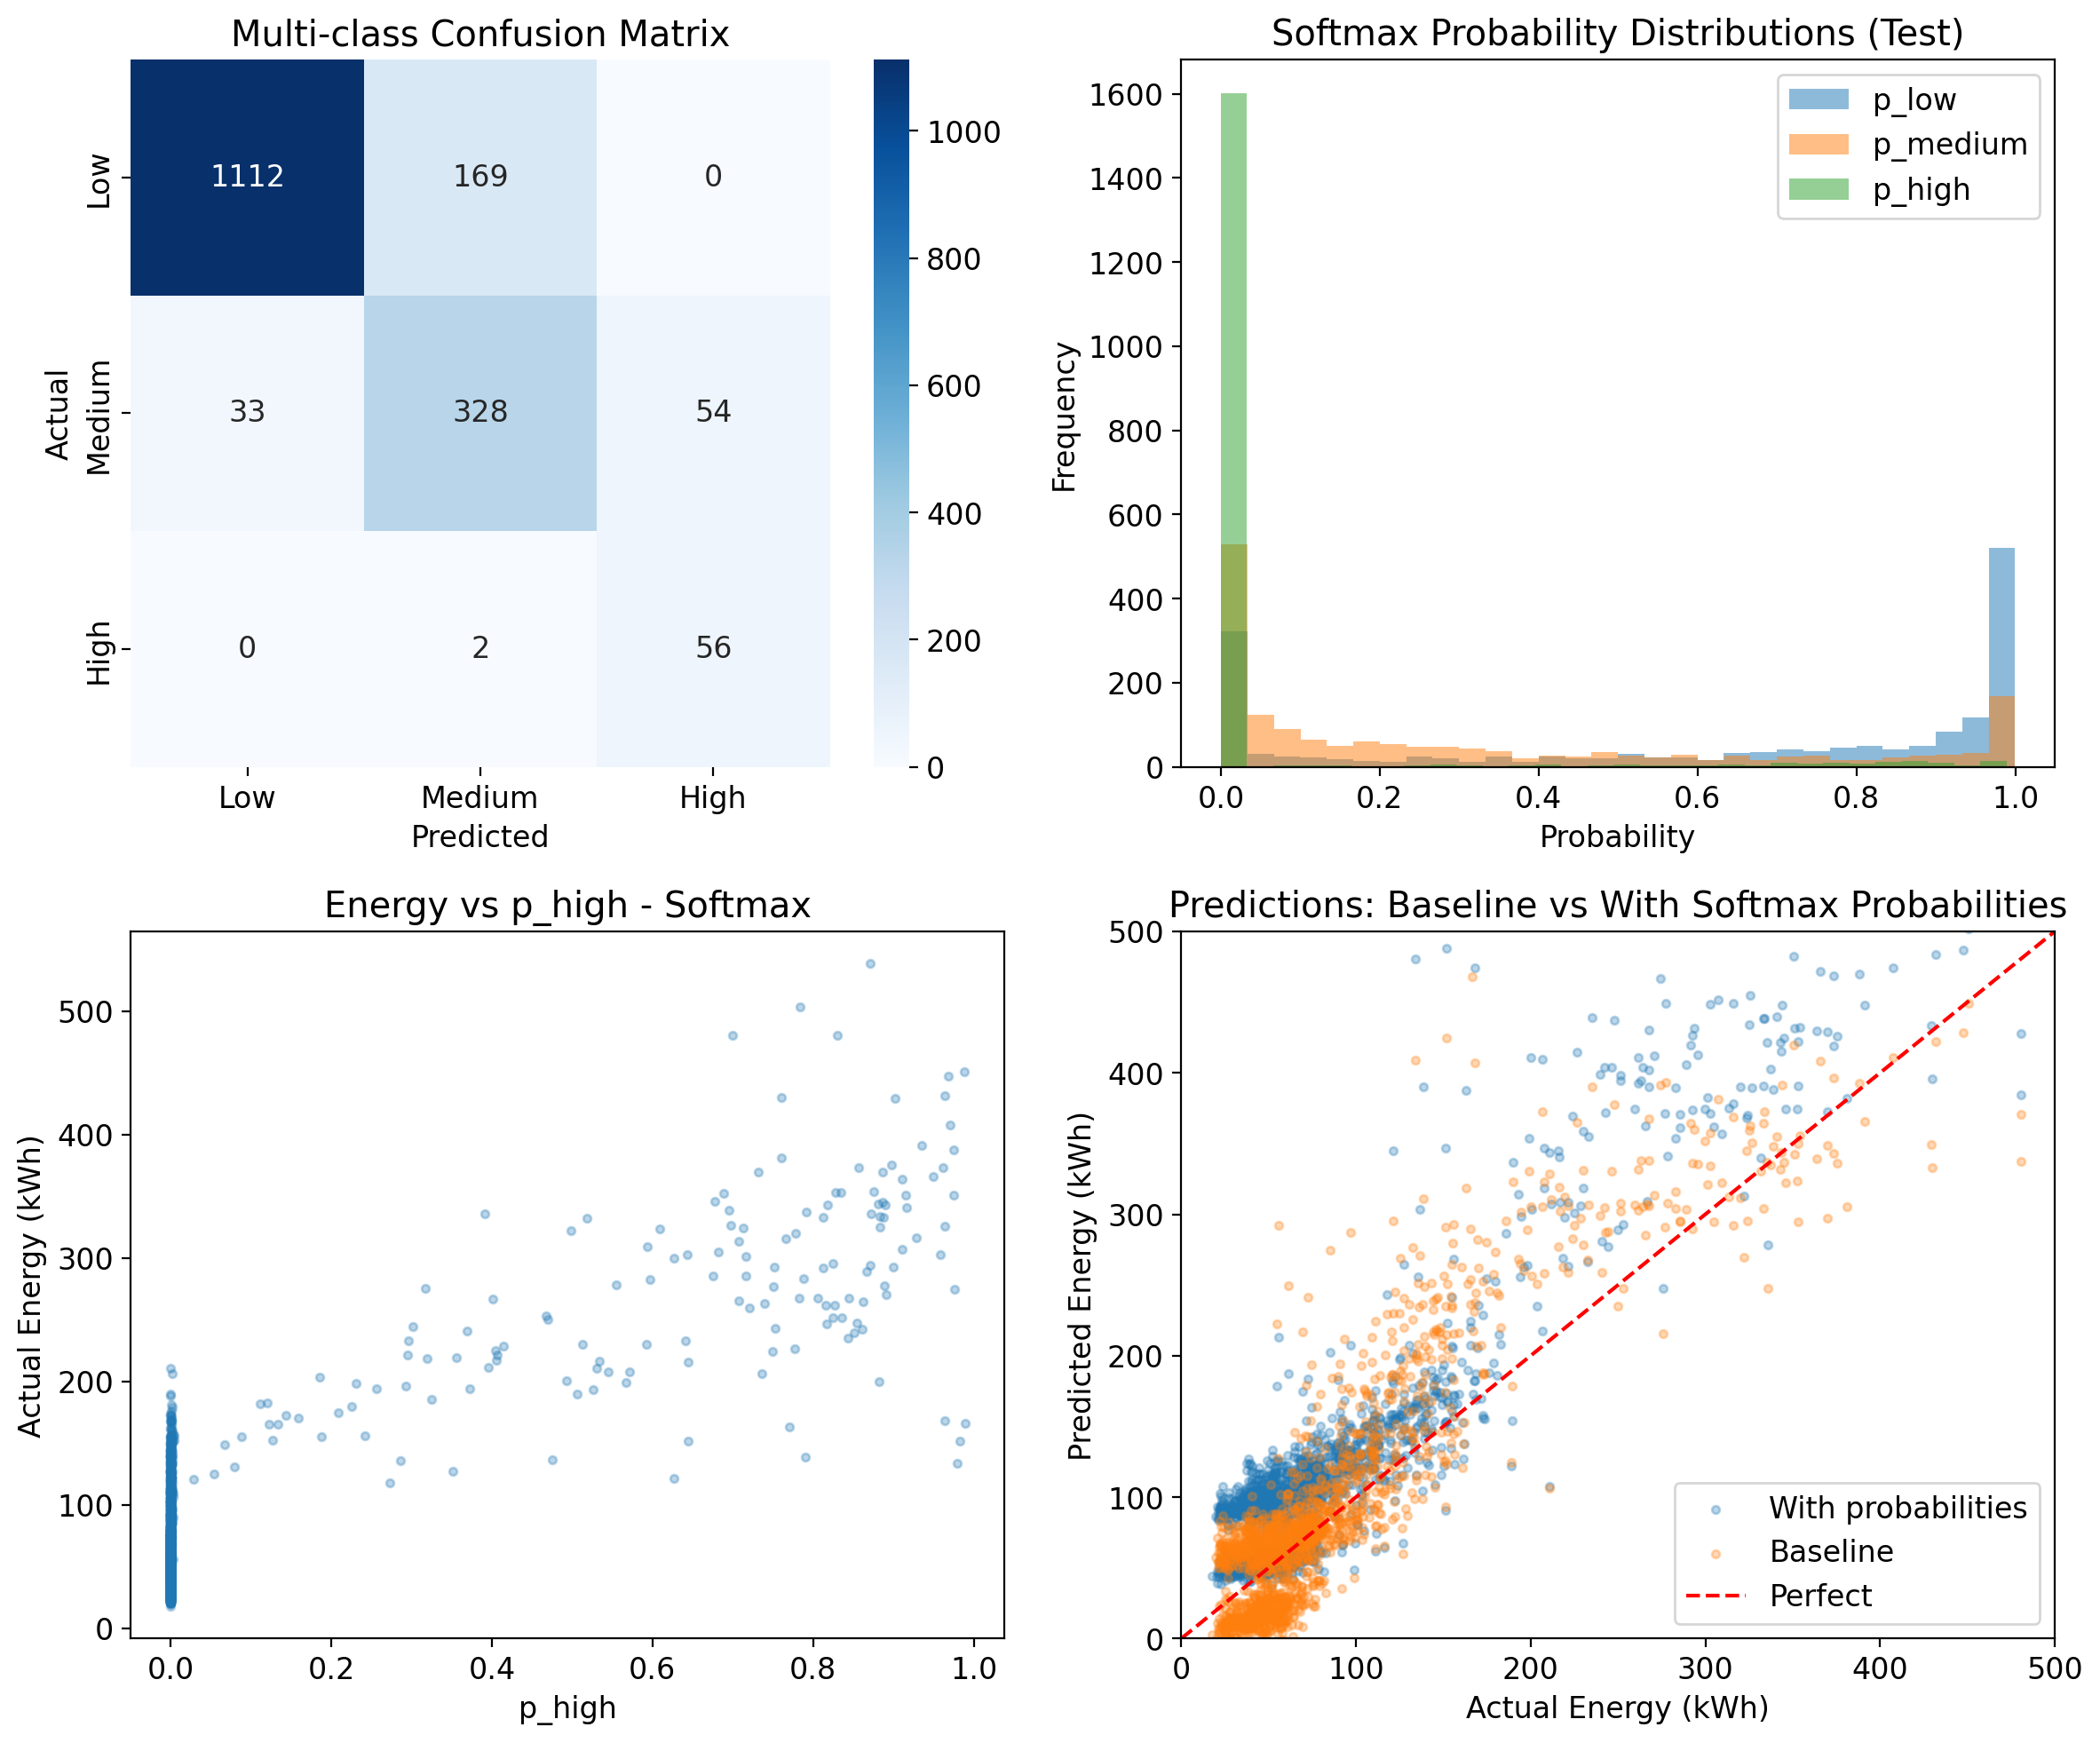

In [992]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 9. Visualization for Option B
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 9a. Confusion matrix
cm = confusion_matrix(y_test_mc, y_pred_mc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=class_names, yticklabels=class_names)
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Multi-class Confusion Matrix')

# 9b. Class probability distributions
axes[0, 1].hist(test_eng['p_low'], bins=30, alpha=0.5, label='p_low')
axes[0, 1].hist(test_eng['p_medium'], bins=30, alpha=0.5, label='p_medium')
axes[0, 1].hist(test_eng['p_high'], bins=30, alpha=0.5, label='p_high')
axes[0, 1].set_xlabel('Probability')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Softmax Probability Distributions (Test)')
axes[0, 1].legend()

# 9c. Actual energy vs P(High)
axes[1, 0].scatter(test_eng['p_high'], test_eng['energie_kwh'], alpha=0.3, s=10)
axes[1, 0].set_xlabel('p_high')
axes[1, 0].set_ylabel('Actual Energy (kWh)')
axes[1, 0].set_title('Energy vs p_high - Softmax')

# 9d. Predictions comparison
axes[1, 1].scatter(y_test_proba, y_pred_with_proba, alpha=0.3, s=10, label='With probabilities')
axes[1, 1].scatter(y_test_final, y_pred_final, alpha=0.3, s=10, label='Baseline')
axes[1, 1].plot([0, 500], [0, 500], 'r--', label='Perfect')
axes[1, 1].set_xlabel('Actual Energy (kWh)')
axes[1, 1].set_ylabel('Predicted Energy (kWh)')
axes[1, 1].set_title('Predictions: Baseline vs With Softmax Probabilities')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 500)
axes[1, 1].set_ylim(0, 500)

plt.tight_layout()

# 10. Summary
print("\n" + "=" * 60)
print("📋 OPTION B SUMMARY: MULTI-CLASS CLASSIFICATION")
print("=" * 60)
print("""
KEY CONCEPTS:
  - Softmax function: σ(z)_j = exp(z_j) / Σ exp(z_k)
  - Converts raw scores to probabilities that sum to 1
  - Used in multinomial logistic regression (default in sklearn 1.5+)
  
APPROACH:
  1. Created 3 consumption classes: Low, Medium, High
     (based on 33rd and 67th percentiles of training data)
  2. Trained multinomial logistic regression with softmax
  3. Extracted P(Low), P(Medium), P(High) for each observation
  4. Used probabilities as additional features for Ridge regression

WHY SOFTMAX PROBABILITIES ARE USEFUL:
  - Capture uncertainty: P(Low)=0.4, P(Medium)=0.4, P(High)=0.2 tells us
    the model is uncertain between Low and Medium
  - Ordinal information: High consumption observations will have higher P(High)
  - Smooth gradient: Unlike binary 0/1, probabilities provide continuous signal

COMPARISON WITH BINARY CLASSIFICATION (Part 5):
  - Binary: P(peak) vs P(not peak) - only 2 states
  - Multi-class: 3 states capture more nuanced consumption levels
  - Softmax ensures probabilities are coherent (sum to 1)
""")
print("=" * 60)

---

## Soumission Kaggle

Générez votre fichier de soumission pour la compétition.

In [993]:
# Générer les prédictions pour Kaggle (sur test_kaggle, sans la cible)

# 1. Apply feature engineering to test_kaggle
test_kaggle_eng = creer_caracteristiques(test_kaggle)
test_kaggle_eng = test_kaggle_eng.dropna()

# 2. Prepare features (same as final model, without P_pointe)
X_kaggle_final = test_kaggle_eng[features_final].values

# 3. Scale using the same scaler as final model
X_kaggle_final_scaled = scaler_final.transform(X_kaggle_final)

# 4. Predict
y_pred_kaggle = model_final.predict(X_kaggle_final_scaled)
y_pred_kaggle = np.maximum(y_pred_kaggle, 0)

# 5. Create submission
submission = pd.DataFrame({
    'id': range(len(test_kaggle_eng)),
    'energie_kwh': y_pred_kaggle
})

submission.to_csv('submission.csv', index=False)
print(f"Fichier de soumission créé: submission.csv ({len(submission)} lignes)")
print("\nStatistiques des prédictions:")
print(f"  Mean: {y_pred_kaggle.mean():.2f} kWh")
print(f"  Std:  {y_pred_kaggle.std():.2f} kWh")
print(f"  Min:  {y_pred_kaggle.min():.2f} kWh")
print(f"  Max:  {y_pred_kaggle.max():.2f} kWh")
submission.head()

Fichier de soumission créé: submission.csv (1754 lignes)

Statistiques des prédictions:
  Mean: 93.15 kWh
  Std:  87.62 kWh
  Min:  0.00 kWh
  Max:  467.75 kWh


,id,energie_kwh
0,0,322.403057
1,1,322.040230
2,2,307.497334
3,3,289.012274
4,4,107.043236


---

## Questions de préparation pour l'entrevue orale

Préparez-vous à répondre à ces questions:

### Fondamentaux
1. Dérivez la solution OLS sur le tableau.
2. Pourquoi avez-vous utilisé une division temporelle et non aléatoire?
3. Que voyez-vous dans vos résidus?

### Régularisation
4. Pourquoi Ridge aide-t-il avec des caractéristiques corrélées?
5. Comment avez-vous choisi λ?
6. Quel coefficient a été le plus réduit? Pourquoi?

### Classification
7. Quelle cible binaire avez-vous choisie? Justifiez.
8. Votre classifieur donne P=0.7. Qu'est-ce que cela signifie?
9. Pourquoi utiliser P(pointe) plutôt qu'un indicateur 0/1?

### Théorie probabiliste
10. Expliquez Ridge comme estimation MAP.
11. Pourquoi la régression logistique minimise-t-elle l'entropie croisée?

### Synthèse
12. Parcourez votre modèle complet étape par étape.
13. Quelle amélioration de R² était la plus importante?
14. Modifiez ce seuil en direct - que prédisez-vous?